# Introduction

This notebook evaluates and compares responses from [Olmo2](https://allenai.org/olmo), using two selected domain-specific language models (DSLLMs), as part of an ongoing AI research project in the **fashion retail** domain. The primary goal is to assess the models' ability to generate contextually relevant and insightful answers in response to a set of predefined prompts.

The experiment was conducted using 30 standardized prompts. 1B parameter have been conducted in Colab. For 7B parameter, These were processed through Python scripts and executed locally via [Ollama](https://ollama.com/) to generate model responses.

All relevant materials — including Python scripts, raw responses, evaluation notebooks, and test artifacts are organized in this shared [folder](https://drive.google.com/drive/folders/1E6_L1kEqG6ivCXxMzCWEkNzVck95YXcH?usp=sharing).


The approach project will use is to preserves a **clear methodological separation**:

- **LLM (Round 1):** Acts as the automated evaluator  
- **Human (Round 2):** Acts as the final reviewer and gold-standard creator

By deferring all human judgments to Round 2, we avoid role overlap and ensure that the **human evaluation covers all prompts**—including those that the LLM failed to assess. This strategy enhances research credibility and supports rigorous post-hoc comparison between LLM and human judgment.


# Table of Contents

[1 Notebook Setup](#scrollTo=Zgo4BO_7XkB9)

[2 Standardized prompts](#scrollTo=8MmulJfsXppi)

[3 Model Selection](#scrollTo=xLiK9AMS5zOe)

[4 Baseline Evaluation Using LLM As A Judge](#scrollTo=W-iys-CWQM6x)

[5 Label-mapped Scoring](#scrollTo=VpXBUy0ZTVct)

[6 Analysis of using LLM as a judge](#scrollTo=75ZK6gnRFcVt)

[7 Human Evaluation As Second Checker](#scrollTo=3TpFB3f3EaOU)

[8 Filling LLM Nulls via Human Review](#scrollTo=FpoSLQuFqXxH)

[9 NLP Metrics Agreement Rate with Average Brand Score Comparison](#scrollTo=6K6a0hg87Kss)

# 1 Notebook Setup

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -qU \
  numpy \
  pandas \
  requests \
  beautifulsoup4 \
  matplotlib \
  seaborn \
  rapidfuzz \
  torch \
  transformers \
  accelerate \
  bitsandbytes \
  langchain \
  langchain-google-genai

In [ ]:
# Standard libraries
import os
import re
import time
import json
import textwrap
import pprint
from pathlib import Path
from datetime import datetime
from collections import OrderedDict
import math

import numpy as np

# Data handling
import pandas as pd

# Web & scraping
import requests
from bs4 import BeautifulSoup

# Colab utilities
from google.colab import drive
from google.colab import userdata  # For pulling secrets

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text similarity
from rapidfuzz import fuzz as rapid_fuzz

# Transformers / LLM
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# LangChain
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

## Define main root path

In [ ]:
# Define path
root = Path("/content/drive/MyDrive/prompt_shared/baseline_analysis/olmo2")

# 2 Standardized prompts

There are 30 standardized prompt as analysis comparison between baseline and after-finetuning phrases

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
# Define file paths
standardized_prompt_path = '/content/drive/MyDrive/prompt_shared/baseline_analysis/standardized_brand_prompt.csv'

In [ ]:
# Try Windows-1252
try:
    standardized_df = pd.read_csv(standardized_prompt_path, encoding='cp1252')
    print("Read with encoding='cp1252' successfully.")
except UnicodeDecodeError:
    # fallback to latin-1
    standardized_df = pd.read_csv(standardized_prompt_path, encoding='latin-1')
    print("Read with encoding='latin-1' as fallback.")

display(standardized_df.head())

Read with encoding='cp1252' successfully.


,prompt_id,prompt_text,Prompt Category,Explanation
0,1,Which fashion retail brands are generally considered the best in the UK today?,Comparison,"Open-ended prompt, General Ranking"
1,2,"Rank Zara, H&M, Primark, and Burberry based on their overall brand presence and public awareness in the fashion industry. Provide justification for the ranking.",Comparison,Fixed-brand ranking prompt to measure general public awareness and brand presence without specific attribute bias.
2,3,"Provide a ranked list of Zara, H&M, Primark, and Burberry based on their overall perception as fashion brands by the general public. Explain your reasoning for the order.",Comparison,Measures how the model perceives general reputation across all brands using an explicit ranked list format.
3,4,"Rank Zara, H&M, Primark, and Burberry by perceived price-to-value.",Comparison,Forces rank comparison on affordability vs. quality.
4,5,"Rank Zara, H&M, Primark, and Burberry by overall customer service experience.",Comparison,Evaluates customer-facing experience.


<a id="model-selection"></a>  
# 3 Model Selection

## Olmo2-7b (base)

**Note:** The code block below might have been intentionally hidden to prevent unintentional multiple downloads during testing of the dataset. This is a best practice to avoid redundant operations that may consume unnecessary resources or lead to duplicate file writes.

## Load the response

In [ ]:
# Define file paths
olmo2_7b_path = root / 'olmo2_7b_results.json'

In [ ]:
# Load JSON files
with open(olmo2_7b_path, 'r') as f:
    olmo2_7b_data = json.load(f)

In [ ]:
# Convert to pandas DataFrame. Adjust normalization if nested structures exist.
olmo2_7b_df = pd.json_normalize(olmo2_7b_data)

In [ ]:
olmo2_7b_df = olmo2_7b_df.copy()

In [ ]:
# Display the data
print("\nOLMO2_7B DataFrame preview:")
display(olmo2_7b_df.head())


OLMO2_7B DataFrame preview:


,prompt,response,time_taken_sec
0,Which fashion retail brands are generally considered the best in the UK today?,"In the UK, there are several renowned fashion retail brands that are highly regarded for their quality and style. Some of them include:\n\n1. **Burberry**: Known for its iconic check pattern and a heritage rich in British fashion, Burberry is often ranked among the best high-end fashion brands.\n\n2. **Alexander McQueen**: Renowned for its daring designs and avant-garde approach, Alexander McQueen is celebrated for its influence on global fashion.\n\n3. **Mulberry**: This brand is famous for its exceptional craftsmanship and luxurious leather goods, attracting a loyal following.\n\n4. **J.Crew**: While primarily an American brand, J.Crew has a strong presence in the UK with its classic, contemporary designs that appeal to a wide audience.\n\n5. **H&M**: Although a mass-market retailer, H&M frequently collaborates with high-profile designers and offers trendy, affordable clothing options.\n\n6. **Topshop**: Famous for its edgy street-wear and high-fashion collaborations, Topshop provides a mix of high-street fashion and celebrity influence.\n\n7. **Rebecca Minkoff**: Known for its modern designs and approachable yet fashionable wardrobe, Rebecca Minkoff is a favorite among many style-conscious consumers.\n\n8. **Zara**: As one of the largest fast-fashion retailers in the world, Zara offers trendy, affordable clothing that changes rapidly with the latest fashion trends.\n\n9. **River Island**: With its blend of contemporary styles and classic pieces, River Island provides a competitive offering in the UK high-street market.\n\nThese brands span various price points and fashion sensibilities, catering to a wide range of consumers seeking quality and style in the UK fashion scene.",201.29
1,"Rank Zara, H&M, Primark, and Burberry based on their overall brand presence and public awareness in the fashion industry. Provide justification for the ranking.","Burberry would rank highest in terms of overall brand presence and public awareness in the fashion industry. Here's why:\n\n1. **Legacy and Reputation**: Burberry has been a longstanding brand in the fashion world since its founding in 1856. It has a rich history and a strong reputation, which contributes to its significant brand presence.\n\n2. **Iconic Status**: Burberry is an iconic fashion label known for its iconic check pattern, which has become synonymous with the brand itself. This recognition and widespread use of their design in popular culture and media amplify their public awareness.\n\n3. **Global Expansion**: Burberry has a strong global presence, with stores all over the world, including iconic locations like London's Regent Street. Their international chain stores and online presence further bolster their visibility and reach.\n\n4. **Collaborations and Partnerships**: Burberry collaborates with various celebrities, influencers, and fashion houses, which extends its brand reach and attracts a wider audience.\n\n5. **Luxury Appeal**: While price points might make it more accessible to a certain demographic, Burberry is positioned as a luxury brand, appealing to fashion-forward individuals who appreciate premium craftsmanship and design. Its luxury status enhances its brand perception and recognition.\n\n6. **Marketing and Social Media Presence**: Burberry actively utilizes social media platforms like Instagram, where they showcase their collections, fashion stories, and engage directly with their audience. This modern marketing strategy significantly contributes to their public awareness.\n\nZara, H&M, and Primark, while also very successful in their markets, might rank lower compared to Burberry due to their more focused business model on fast fashion at affordable prices, which caters to a different demographic and market segment than the luxury appeal of Burberry. They are certainly influential within their niches but do not carry the same level of inter

In [ ]:
# Normalize text in standardized_df
standardized_df['prompt_norm'] = (
    standardized_df['prompt_text']
      .astype(str)
      .str.strip()
      .str.lower()
)

In [ ]:
# Normalize text in olmo2 response
olmo2_7b_df['prompt_norm'] = (
    olmo2_7b_df['prompt']
      .astype(str)
      .str.strip()
      .str.lower()
)

In [ ]:
# Merge olmo2 and standardized prompt
merged_olmo2 = pd.merge(
    olmo2_7b_df,
    standardized_df[['prompt_norm', 'Prompt Category']],
    on='prompt_norm',
    how='left'
)
merged_olmo2

,prompt,response,time_taken_sec,prompt_norm,Prompt Category
0,Which fashion retail brands are generally considered the best in the UK today?,"In the UK, there are several renowned fashion retail brands that are highly regarded for their quality and style. Some of them include:\n\n1. **Burberry**: Known for its iconic check pattern and a heritage rich in British fashion, Burberry is often ranked among the best high-end fashion brands.\n\n2. **Alexander McQueen**: Renowned for its daring designs and avant-garde approach, Alexander McQueen is celebrated for its influence on global fashion.\n\n3. **Mulberry**: This brand is famous for its exceptional craftsmanship and luxurious leather goods, attracting a loyal following.\n\n4. **J.Crew**: While primarily an American brand, J.Crew has a strong presence in the UK with its classic, contemporary designs that appeal to a wide audience.\n\n5. **H&M**: Although a mass-market retailer, H&M frequently collaborates with high-profile designers and offers trendy, affordable clothing options.\n\n6. **Topshop**: Famous for its edgy street-wear and high-fashion collaborations, Topshop provides a mix of high-street fashion and celebrity influence.\n\n7. **Rebecca Minkoff**: Known for its modern designs and approachable yet fashionable wardrobe, Rebecca Minkoff is a favorite among many style-conscious consumers.\n\n8. **Zara**: As one of the largest fast-fashion retailers in the world, Zara offers trendy, affordable clothing that changes rapidly with the latest fashion trends.\n\n9. **River Island**: With its blend of contemporary styles and classic pieces, River Island provides a competitive offering in the UK high-street market.\n\nThese brands span various price points and fashion sensibilities, catering to a wide range of consumers seeking quality and style in the UK fashion scene.",201.29,which fashion retail brands are generally considered the best in the uk today?,Comparison
1,"Rank Zara, H&M, Primark, and Burberry based on their overall brand presence and public awareness in the fashion industry. Provide justification for the ranking.","Burberry would rank highest in terms of overall brand presence and public awareness in the fashion industry. Here's why:\n\n1. **Legacy and Reputation**: Burberry has been a longstanding brand in the fashion world since its founding in 1856. It has a rich history and a strong reputation, which contributes to its significant brand presence.\n\n2. **Iconic Status**: Burberry is an iconic fashion label known for its iconic check pattern, which has become synonymous with the brand itself. This recognition and widespread use of their design in popular culture and media amplify their public awareness.\n\n3. **Global Expansion**: Burberry has a strong global presence, with stores all over the world, including iconic locations like London's Regent Street. Their international chain stores and online presence further bolster their visibility and reach.\n\n4. **Collaborations and Partnerships**: Burberry collaborates with various celebrities, influencers, and fashion houses, which extends its brand reach and attracts a wider audience.\n\n5. **Luxury Appeal**: While price points might make it more accessible to a certain demographic, Burberry is positioned as a luxury brand, appealing to fashion-forward individuals who appreciate premium craftsmanship and design. Its luxury status enhances its brand perception and recognition.\n\n6. **Marketing and Social Media Presence**: Burberry actively utilizes social media platforms like Instagram, where they showcase their collections, fashion stories, and engage directly with their audience. This modern marketing strategy significantly contributes to their public awareness.\n\nZara, H&M, and Primark, while also very successful in their markets, might rank lower compared to Burberry due to their more focused business model on fast fashion at affordable prices, which caters to a different demographic and market segment than the 

In [ ]:
# Now rename or drop helper columns:
merged_olmo2 = merged_olmo2.rename(columns={'Prompt Category': 'prompt_category'})

In [ ]:
# Drop the normalized and redundant columns if you like:
merged_olmo2 = merged_olmo2.drop(columns=['prompt_norm'])

In [ ]:
print("Merged DataFrame preview:")
display(merged_olmo2.head())

Merged DataFrame preview:


,prompt,response,time_taken_sec,prompt_category
0,Which fashion retail brands are generally considered the best in the UK today?,"In the UK, there are several renowned fashion retail brands that are highly regarded for their quality and style. Some of them include:\n\n1. **Burberry**: Known for its iconic check pattern and a heritage rich in British fashion, Burberry is often ranked among the best high-end fashion brands.\n\n2. **Alexander McQueen**: Renowned for its daring designs and avant-garde approach, Alexander McQueen is celebrated for its influence on global fashion.\n\n3. **Mulberry**: This brand is famous for its exceptional craftsmanship and luxurious leather goods, attracting a loyal following.\n\n4. **J.Crew**: While primarily an American brand, J.Crew has a strong presence in the UK with its classic, contemporary designs that appeal to a wide audience.\n\n5. **H&M**: Although a mass-market retailer, H&M frequently collaborates with high-profile designers and offers trendy, affordable clothing options.\n\n6. **Topshop**: Famous for its edgy street-wear and high-fashion collaborations, Topshop provides a mix of high-street fashion and celebrity influence.\n\n7. **Rebecca Minkoff**: Known for its modern designs and approachable yet fashionable wardrobe, Rebecca Minkoff is a favorite among many style-conscious consumers.\n\n8. **Zara**: As one of the largest fast-fashion retailers in the world, Zara offers trendy, affordable clothing that changes rapidly with the latest fashion trends.\n\n9. **River Island**: With its blend of contemporary styles and classic pieces, River Island provides a competitive offering in the UK high-street market.\n\nThese brands span various price points and fashion sensibilities, catering to a wide range of consumers seeking quality and style in the UK fashion scene.",201.29,Comparison
1,"Rank Zara, H&M, Primark, and Burberry based on their overall brand presence and public awareness in the fashion industry. Provide justification for the ranking.","Burberry would rank highest in terms of overall brand presence and public awareness in the fashion industry. Here's why:\n\n1. **Legacy and Reputation**: Burberry has been a longstanding brand in the fashion world since its founding in 1856. It has a rich history and a strong reputation, which contributes to its significant brand presence.\n\n2. **Iconic Status**: Burberry is an iconic fashion label known for its iconic check pattern, which has become synonymous with the brand itself. This recognition and widespread use of their design in popular culture and media amplify their public awareness.\n\n3. **Global Expansion**: Burberry has a strong global presence, with stores all over the world, including iconic locations like London's Regent Street. Their international chain stores and online presence further bolster their visibility and reach.\n\n4. **Collaborations and Partnerships**: Burberry collaborates with various celebrities, influencers, and fashion houses, which extends its brand reach and attracts a wider audience.\n\n5. **Luxury Appeal**: While price points might make it more accessible to a certain demographic, Burberry is positioned as a luxury brand, appealing to fashion-forward individuals who appreciate premium craftsmanship and design. Its luxury status enhances its brand perception and recognition.\n\n6. **Marketing and Social Media Presence**: Burberry actively utilizes social media platforms like Instagram, where they showcase their collections, fashion stories, and engage directly with their audience. This modern marketing strategy significantly contributes to their public awareness.\n\nZara, H&M, and Primark, while also very successful in their markets, might rank lower compared to Burberry due to their more focused business model on fast fashion at affordable prices, which caters to a different demographic and market segment than the luxury appeal of Burberry. They are certainly influential within their niches but do not ca

## Time taken

In [ ]:
# Ensure it's numeric just in case
merged_olmo2['time_taken_sec'] = pd.to_numeric(merged_olmo2['time_taken_sec'], errors='coerce')

# Compute average time
avg_time_all = merged_olmo2['time_taken_sec'].mean().round(2)

print(f"Average time taken across all prompts: {avg_time_all} seconds")

Average time taken across all prompts: 206.62 seconds


## Recategorize the prompt type

In [ ]:
# Rename categories as specified
category_mapping = {
    "Product Category": "Business Insight",
    "Customer Persona": "Business Insight",
    "Ranking Comparison": "Comparison"
}

merged_olmo2["prompt_category_renamed"] = merged_olmo2["prompt_category"].replace(category_mapping)

In [ ]:
# Replace original prompt_category with the renamed version
merged_olmo2["prompt_category"] = merged_olmo2["prompt_category"].replace(category_mapping)

In [ ]:
# Remove the temporary column after replacement
merged_olmo2.drop(columns=["prompt_category_renamed"], inplace=True)

In [ ]:
# Ensure numeric
merged_olmo2['time_taken_sec'] = pd.to_numeric(merged_olmo2['time_taken_sec'], errors='coerce')

# Group, summarize, and round using renamed category
summary = (
    merged_olmo2.groupby('prompt_category')['time_taken_sec']
    .mean()
    .round(2)
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'time_taken_sec': 'avg_time_sec'})
)

# Add temporary column in minutes
summary['avg_time_min'] = (summary['avg_time_sec'] / 60).round(2)

display(summary)

,prompt_category,avg_time_sec,avg_time_min
0,Comparison,214.39,3.57
1,Bias Detection,210.21,3.50
2,Business Insight,200.43,3.34


Although the smaller model is faster, its responses are inaccurate and fall below acceptable standards.

## Separate category

separate category to try the system prompt

In [ ]:
# Define a mapping from var name -> category values
filters = {
    'olmo2_comparison': ['Comparison', 'Ranking Comparison'],
    'olmo2_insight': ['Business Insight'],
    'olmo2_bias': ['Bias Detection', 'Product Category', 'Customer Persona']
}

# Build each filtered DataFrame
for var, cat in filters.items():
    globals()[var] = merged_olmo2[merged_olmo2['prompt_category'].isin(cat)].copy()
    print(f"{var}: {len(globals()[var])} rows")

# Optional: peek at one result
display(olmo2_comparison.head())

olmo2_comparison: 7 rows
olmo2_insight: 14 rows
olmo2_bias: 9 rows


,prompt,response,time_taken_sec,prompt_category
0,Which fashion retail brands are generally considered the best in the UK today?,"In the UK, there are several renowned fashion retail brands that are highly regarded for their quality and style. Some of them include:\n\n1. **Burberry**: Known for its iconic check pattern and a heritage rich in British fashion, Burberry is often ranked among the best high-end fashion brands.\n\n2. **Alexander McQueen**: Renowned for its daring designs and avant-garde approach, Alexander McQueen is celebrated for its influence on global fashion.\n\n3. **Mulberry**: This brand is famous for its exceptional craftsmanship and luxurious leather goods, attracting a loyal following.\n\n4. **J.Crew**: While primarily an American brand, J.Crew has a strong presence in the UK with its classic, contemporary designs that appeal to a wide audience.\n\n5. **H&M**: Although a mass-market retailer, H&M frequently collaborates with high-profile designers and offers trendy, affordable clothing options.\n\n6. **Topshop**: Famous for its edgy street-wear and high-fashion collaborations, Topshop provides a mix of high-street fashion and celebrity influence.\n\n7. **Rebecca Minkoff**: Known for its modern designs and approachable yet fashionable wardrobe, Rebecca Minkoff is a favorite among many style-conscious consumers.\n\n8. **Zara**: As one of the largest fast-fashion retailers in the world, Zara offers trendy, affordable clothing that changes rapidly with the latest fashion trends.\n\n9. **River Island**: With its blend of contemporary styles and classic pieces, River Island provides a competitive offering in the UK high-street market.\n\nThese brands span various price points and fashion sensibilities, catering to a wide range of consumers seeking quality and style in the UK fashion scene.",201.29,Comparison
1,"Rank Zara, H&M, Primark, and Burberry based on their overall brand presence and public awareness in the fashion industry. Provide justification for the ranking.","Burberry would rank highest in terms of overall brand presence and public awareness in the fashion industry. Here's why:\n\n1. **Legacy and Reputation**: Burberry has been a longstanding brand in the fashion world since its founding in 1856. It has a rich history and a strong reputation, which contributes to its significant brand presence.\n\n2. **Iconic Status**: Burberry is an iconic fashion label known for its iconic check pattern, which has become synonymous with the brand itself. This recognition and widespread use of their design in popular culture and media amplify their public awareness.\n\n3. **Global Expansion**: Burberry has a strong global presence, with stores all over the world, including iconic locations like London's Regent Street. Their international chain stores and online presence further bolster their visibility and reach.\n\n4. **Collaborations and Partnerships**: Burberry collaborates with various celebrities, influencers, and fashion houses, which extends its brand reach and attracts a wider audience.\n\n5. **Luxury Appeal**: While price points might make it more accessible to a certain demographic, Burberry is positioned as a luxury brand, appealing to fashion-forward individuals who appreciate premium craftsmanship and design. Its luxury status enhances its brand perception and recognition.\n\n6. **Marketing and Social Media Presence**: Burberry actively utilizes social media platforms like Instagram, where they showcase their collections, fashion stories, and engage directly with their audience. This modern marketing strategy significantly contributes to their public awareness.\n\nZara, H&M, and Primark, while also very successful in their markets, might rank lower compared to Burberry due to their more focused business model on fast fashion at affordable prices, which caters to a different demographic and market segment than the luxury appeal of Burberry. They are certainly influential within their niches but do not ca

In [ ]:
# Create cleaned version of the DataFrame
olmo2_comparison_clean = olmo2_comparison.copy()
olmo2_comparison_clean["response"] = olmo2_comparison_clean["response"].str.replace("\\n\\n", "\n", regex=True)

# Print responses with line-wrapping (no HTML)
for i, row in olmo2_comparison_clean.head(5).iterrows():
    prompt = row["prompt"]
    response = row["response"]

    print(f"=== Response {i+1} ===")
    print("Prompt:")
    print(textwrap.fill(prompt, width=100))  # wrap prompt to 100 characters
    print("\nResponse:")
    for paragraph in response.split("\n"):
        print(textwrap.fill(paragraph, width=100))
        print()
    print("=" * 100)


=== Response 1 ===
Prompt:
Which fashion retail brands are generally considered the best in the UK today?

Response:
In the UK, there are several renowned fashion retail brands that are highly regarded for their
quality and style. Some of them include:

1. **Burberry**: Known for its iconic check pattern and a heritage rich in British fashion, Burberry
is often ranked among the best high-end fashion brands.

2. **Alexander McQueen**: Renowned for its daring designs and avant-garde approach, Alexander
McQueen is celebrated for its influence on global fashion.

3. **Mulberry**: This brand is famous for its exceptional craftsmanship and luxurious leather goods,
attracting a loyal following.

4. **J.Crew**: While primarily an American brand, J.Crew has a strong presence in the UK with its
classic, contemporary designs that appeal to a wide audience.

5. **H&M**: Although a mass-market retailer, H&M frequently collaborates with high-profile designers
and offers trendy, affordable clothing o

<a id="baseline-evaluation-using-llm-as-a-judge"></a>  
# 4 Baseline Evaluation Using LLM As A Judge


**Null Return Rate Policy:** For this evaluation round, we aim to keep the **null return rate below 20%**, a slightly relaxed threshold due to our current use of **Gemini 2.5 Flash (free version)**. While this model processes quickly, it may have limitations in understanding nuanced context or making precise judgments. As such, a higher null rate is acceptable during early-stage prototyping. For future research phases, we plan to tighten this threshold to **≤10%**, especially when shifting to more advanced models (e.g., Gemini 1.5 Pro or GPT-4) in a production setting.

In [ ]:
# Load your Gemini key into an environment variable
os.environ["GOOGLE_API_KEY"] = userdata.get("gemini_2")  # the secret is named "gemini"

In [ ]:
# Set up Gemini LLM client for evaluation ---
llm_eval = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",       # Using Gemini 2.5 Flash model (faster, lightweight)
    temperature=0,                  # Set deterministic behavior (no randomness)
    top_p=1.0,                    # Use full probability mass, top_p=1.0 alongside temperature=0.0 further minimizes any sampling variability.
    max_output_tokens=1024,        # Allow long enough output to fit full JSON
    model_kwargs={
        "response_mime_type": "application/json",  # Ensure output is formatted as JSON
        "stop_sequences": ["```"]                  # Stop generation if model starts code-fence
    }
)

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning: Parameters {'response_mime_type'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  exec(code_obj, self.user_global_ns, self.user_ns)


## System Prompt Evaluation

In [ ]:
SYSTEM_PROMPT = """
You are an automated evaluator. Your task is to analyze a response to a user prompt and return a structured evaluation in **strict JSON format only**.

You must ALWAYS provide a full answer, with NO empty, null, NaN, or omitted values – every key must be filled as per instructions below. If unsure, always choose the best reasonable estimate based on available information, rather than leaving anything blank or defaulting to "Unclear" or "Missing" unless absolutely necessary. Confidence is required – always prefer a reasoned guess over indecision.

LANGUAGE NOTE
• If the user prompt or assistant response is in a language other than English, first translate it to English internally, then apply all evaluation rules exactly as defined.

When you respond, follow the three steps below:

1. **Copy** the TEMPLATE exactly as shown.
2. **Overwrite** every value with your final judgement (do not remove any keys, never leave empty).
3. Output **only** the final JSON object – no markdown, no commentary.

--------------------------------------------------------------------
🔒 TEMPLATE  – copy & overwrite
{
  "template_version": "1.0",
  "clarity": "Unclear",
  "relevance": "Off-topic",
  "completeness": "Missing",
  "ranking_detected": false,
  "ranking_type": "none",
  "brand_score": { "Zara": 0.0, "H&M": 0.0, "Primark": 0.0, "Burberry": 0.0 }
}
--------------------------------------------------------------------

You must NEVER return null, empty strings, NaN, or omit any key. If unsure, always give your most reasonable estimate for every metric and score.

--------------------------------------------------------------------
REQUIRED JSON SCHEMA

{
  "template_version": "1.0",
  "clarity": "<Clear | Somewhat Clear | Unclear>",
  "relevance": "<Relevant | Partial | Off-topic>",
  "completeness": "<Complete | Partial | Missing>",
  "ranking_detected": <true | false>,
  "ranking_type": "<explicit | soft_rank | none>",

  <<<UPDATE BRAND LIST here>>>
  "brand_score": {
    "Zara": <float between 0.0 and 1.0>,
    "H&M": <float between 0.0 and 1.0>,
    "Primark": <float between 0.0 and 1.0>,
    "Burberry": <float between 0.0 and 1.0>
  }
}

--------------------------------------------------------------------
💡 DECISION FLOW — follow these 4 steps in order, never skip or leave any value blank

1) BRAND MENTION
   • If the response contains a brand name (case-insensitive) → it is “mentioned”.
   • Any brand not listed in the brand_score schema (i.e., not Zara, H&M, Primark, or Burberry) **must** receive 0.0 in brand_score, even if mentioned or ranked.

2) RANKING TYPE
   • Numbered or clearly ordered list that includes ≥ 2 of the four target brands →
     ranking_detected = true, ranking_type = explicit.

   • Otherwise, set ranking_detected = true, ranking_type = soft_rank **if at least one of the following is true**:
     – Ranking language appears (e.g. *better, best, top, leads, most affordable, strongest option, stronger, wins, first, highest, lowest, earliest, latest, earlier, older, newer, dominates, outperforms*).
     – The **user’s question** is clearly comparative (“vs”, “or”, “first”, “earlier than”, etc.) **and** the answer chooses a side, even if it names just one brand.

   • Else → ranking_detected = false, ranking_type = none.

3) SCORE ASSIGNMENT
   • **If ranking_detected = true:**
     – **explicit**: 1st = 1.0, 2nd = 0.6, 3rd = 0.4, 4th = 0.1 for schema brands.
     – **soft_rank**: use approximate shares (e.g. 0.7 / 0.5 / 0.3). Ties share a value.
       If only one clear favourite among schema brands, give it 0.6–0.7 and other *mentioned* schema brands 0.4; unmentioned schema brands stay 0.0.
     – Non-schema brands always score 0.0.
     – **Note:** If a ranking is detected but none of the four schema brands appear, keep ranking_detected = true and leave all four scores 0.0.

   • **If ranking_detected = false (ranking_type = none):**
     – **Fallback barrier:** if the response is obvious hallucination or mere repetition → all scores 0.0.
     – **Single-brand mention:** exactly one schema brand mentioned (relevance ∈ {Relevant, Partial}) → that brand 0.5, others 0.0.
     – **Multi-brand positive:** ≥ 2 schema brands praised without ranking language → split 1.0 equally.
       *e.g. 3 brands → 0.3 each; 2 brands → 0.5 each.*
     – **All other cases:** all brand scores 0.0.

4) LABEL QUALITY
   • clarity: fluent & readable?
   • relevance: answers the user’s intent?
   • completeness: gives enough reasoning?

→ For vague, incomplete, or ambiguous prompts (e.g. sustainability, bias, aesthetic, or even when the response is minimal), you **must still provide your best-guess estimate** based on the text provided. Always fill every field.

Never skip, never leave a field blank, and never return null. If in doubt, provide your most likely estimate based on evidence or context.

--------------------------------------------------------------------
EXAMPLES & EDGE CASES  (selected)

• Soft-rank example:
  “Brand A is better than B.” →
  ranking_detected = true, ranking_type = soft_rank,
  { "Brand A": 0.7, "Brand B": 0.5 }

• Explicit list example:
  “1) Burberry  2) Zara  3) H&M” →
  ranking_detected = true, ranking_type = explicit,
  { "Burberry": 1.0, "Zara": 0.6, "H&M": 0.4, "Primark": 0.0 }

• Single-brand mention:
  “H&M is the best sustainable brand.” →
  ranking_detected = false,
  { "H&M": 0.5, others 0.0 }

• Comparative question (within schema):
  Q: “Which is cheaper, Zara, H&M, or Burberry?”
  A: “Zara might be considered the cheapest, followed by H&M. These two brands are generally affordable.” →
  ranking_detected = true, ranking_type = soft_rank,
  { "Zara": 0.7, "H&M": 0.5, "Primark": 0.0, "Burberry": 0.0 }

• Off-topic comparison (e.g., bands):
  No schema brands present → and no ranking detected; relevance is evaluated as off-topic:
  ranking_detected = false, ranking_type = none, all scores 0.0

--------------------------------------------------------------------
**Crucial Fallback for Ambiguous or Unclear Responses**
*Only use this when there is truly NO information present for any metric, or the input is pure nonsense.*

{
  "clarity": "Unclear",
  "relevance": "Off-topic",
  "completeness": "Missing",
  "ranking_detected": false,
  "ranking_type": "none",
  "brand_score": { "Zara": 0.0, "H&M": 0.0, "Primark": 0.0, "Burberry": 0.0 }
}

--------------------------------------------------------------------
REMINDERS
• **Every key must be present** – never return null, NaN, empty strings, or omit keys.
• All numbers must be floats with one decimal (e.g. 0.5).
• If unsure about ranking_detected → lean **false**.
• If unsure about ranking_type → lean **soft_rank** (unless fallback).
• Confidence is preferred: an estimate is better than missing data.
• **You must always provide a completed JSON with all fields filled with your best estimate.**
"""


In [ ]:
# expected_brands = ["Zara", "H&M", "Primark", "Burberry"]

In [ ]:
# def safe_extract_json(text: str):
#     if text.startswith("```"):
#         text = text[text.find("{"):]
#     match = re.search(r"\{.*\}", text, flags=re.DOTALL)
#     if not match:
#         return None
#     try:
#         return json.loads(match.group())
#     except json.JSONDecodeError:
#         return None

In [ ]:
# def judge_with_langchain(prompt: str, response: str, expected_brands: list[str]):
#     full_prompt = f"""
# Here is the prompt and the response to evaluate:

# Prompt:
# \"\"\"{prompt}\"\"\"

# Response:
# \"\"\"{response}\"\"\"

# Evaluate the response according to the four metrics described in the system prompt.
# """
#     try:
#         result = llm_eval.invoke([
#             {"role": "system", "content": SYSTEM_PROMPT},
#             {"role": "user",   "content": full_prompt}
#         ])

#         raw_output = result.content.strip()
#         print("RAW LLM OUTPUT ↓")
#         print(raw_output)
#         print("=" * 50)

#         parsed = safe_extract_json(raw_output)
#         if parsed is None:
#             return None

#         for brand in expected_brands:
#             parsed.setdefault("brand_score", {}).setdefault(brand, 0.0)

#         parsed["brand_score"] = {
#             b: round(float(v), 2) for b, v in parsed["brand_score"].items()
#         }

#         return parsed

#     except Exception as e:
#         print(f"[judge_with_langchain error] {e}")
#         return None

## Apply System Prompt to Main Dataframe

<div style="
    background-color: #fff3cd;
    color: #856404;
    border: 1px solid #ffeeba;
    padding: 12px;
    border-radius: 4px;
    font-family: sans-serif;
">

**Note:** The code block below might have been intentionally hidden to prevent unintended redundant operations and conserve LLM resources.
</div>


In [ ]:
# subset = merged_olmo2
# results = []

# for i, (idx, row) in enumerate(subset.iterrows(), start=1):
#     prompt = row["prompt"]
#     response = row["response"]

#     print("=" * 100)
#     print(f"=== Response {i} (row {idx}) ===")

#     eval_dict = judge_with_langchain(prompt, response, expected_brands)

#     if eval_dict:
#         eval_dict["row_index"] = idx
#         results.append(eval_dict)
#         print(json.dumps(eval_dict, indent=2))
#     else:
#         results.append({"row_index": idx})
#         print("[No valid output returned]")

In [ ]:
# eval_df = pd.json_normalize(results)
# merged_olmo2_eval = merged_olmo2.merge(
#     eval_df,
#     left_index=True,
#     right_on="row_index",
#     how="left"
# )

In [ ]:
# eval_df.head(30)

In [ ]:
# pd.reset_option('display.max_colwidth')

In [ ]:
# merged_olmo2_eval

In [ ]:
# merged_olmo2_eval.head()

In [ ]:
# merged_olmo2_eval.columns = merged_olmo2_eval.columns.str.lower()

In [ ]:
# merged_olmo2_eval.info()

## Save as a checkpoint

Save the checkpoint file before revised the prompt

**Note:** The code block below might have been intentionally hidden to prevent unintentional multiple downloads during testing of the dataset. This is a best practice to avoid redundant operations that may consume unnecessary resources or lead to duplicate file writes.

In [ ]:
# Save to CSV before finalization
output_path = root / "olmo2_7b_results_before_used.csv"
# merged_olmo2_eval.to_csv(output_path, index=False)

In [ ]:
output_path = root / "olmo2_7b_results_before_used.csv"
merged_olmo2_eval = pd.read_csv(output_path)

<a id="label-mapped-scoring"></a>  
# 5 Label-mapped Scoring

The project use label-mapped scorring to evaluate the scores

**Evaluation Scoring Mapping**

| **Metric**      | **Label**         | **Mapped Score** |
|------------------|--------------------|------------------|
| **Clarity**       | Clear              | +1               |
|                  | Somewhat Clear     | +0.5             |
|                  | Unclear            | 0                |
| **Relevance**    | Relevant           | +1               |
|                  | Partial            | +0.5             |
|                  | Off-topic          | 0                |
| **Completeness** | Complete           | +1               |
|                  | Partial            | +0.5             |
|                  | Missing            | 0                |


In [ ]:
# Load the data
output_path = root / "olmo2_7b_results_before_used.csv"
df_loaded = pd.read_csv(output_path)

In [ ]:
df_loaded.head()

,prompt,response,time_taken_sec,prompt_category,row_index,template_version,clarity,relevance,completeness,ranking_detected,ranking_type,brand_score.zara,brand_score.h&m,brand_score.primark,brand_score.burberry
0,Which fashion retail brands are generally considered the best in the UK today?,"In the UK, there are several renowned fashion retail brands that are highly regarded for their quality and style. Some of them include:\n\n1. **Burberry**: Known for its iconic check pattern and a heritage rich in British fashion, Burberry is often ranked among the best high-end fashion brands.\n\n2. **Alexander McQueen**: Renowned for its daring designs and avant-garde approach, Alexander McQueen is celebrated for its influence on global fashion.\n\n3. **Mulberry**: This brand is famous for its exceptional craftsmanship and luxurious leather goods, attracting a loyal following.\n\n4. **J.Crew**: While primarily an American brand, J.Crew has a strong presence in the UK with its classic, contemporary designs that appeal to a wide audience.\n\n5. **H&M**: Although a mass-market retailer, H&M frequently collaborates with high-profile designers and offers trendy, affordable clothing options.\n\n6. **Topshop**: Famous for its edgy street-wear and high-fashion collaborations, Topshop provides a mix of high-street fashion and celebrity influence.\n\n7. **Rebecca Minkoff**: Known for its modern designs and approachable yet fashionable wardrobe, Rebecca Minkoff is a favorite among many style-conscious consumers.\n\n8. **Zara**: As one of the largest fast-fashion retailers in the world, Zara offers trendy, affordable clothing that changes rapidly with the latest fashion trends.\n\n9. **River Island**: With its blend of contemporary styles and classic pieces, River Island provides a competitive offering in the UK high-street market.\n\nThese brands span various price points and fashion sensibilities, catering to a wide range of consumers seeking quality and style in the UK fashion scene.",201.29,Comparison,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Rank Zara, H&M, Primark, and Burberry based on their overall brand presence and public awareness in the fashion industry. Provide justification for the ranking.","Burberry would rank highest in terms of overall brand presence and public awareness in the fashion industry. Here's why:\n\n1. **Legacy and Reputation**: Burberry has been a longstanding brand in the fashion world since its founding in 1856. It has a rich history and a strong reputation, which contributes to its significant brand presence.\n\n2. **Iconic Status**: Burberry is an iconic fashion label known for its iconic check pattern, which has become synonymous with the brand itself. This recognition and widespread use of their design in popular culture and media amplify their public awareness.\n\n3. **Global Expansion**: Burberry has a strong global presence, with stores all over the world, including iconic locations like London's Regent Street. Their international chain stores and online presence further bolster their visibility and reach.\n\n4. **Collaborations and Partnerships**: Burberry collaborates with various celebrities, influencers, and fashion houses, which extends its brand reach and attracts a wider audience.\n\n5. **Luxury Appeal**: While price points might make it more accessible to a certain demographic, Burberry is positioned as a luxury brand, appealing to fashion-forward individuals who appreciate premium craftsmanship and design. Its luxury status enhances its brand perception and recognition.\n\n6. **Marketing and Social Media Presence**: Burberry actively utilizes social media platforms like Instagram, where they showcase their collections, fashion stories, and engage directly with their audience. This modern marketing strategy significantly contributes to their public awareness.\n\nZara, H&M, and Primark, while also very successful in their markets, might rank lower compared to Burberry due to their more focused business

In [ ]:
df_loaded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   prompt                30 non-null     object 
 1   response              30 non-null     object 
 2   time_taken_sec        30 non-null     float64
 3   prompt_category       30 non-null     object 
 4   row_index             30 non-null     int64  
 5   template_version      24 non-null     float64
 6   clarity               24 non-null     object 
 7   relevance             24 non-null     object 
 8   completeness          24 non-null     object 
 9   ranking_detected      24 non-null     object 
 10  ranking_type          24 non-null     object 
 11  brand_score.zara      24 non-null     float64
 12  brand_score.h&m       24 non-null     float64
 13  brand_score.primark   24 non-null     float64
 14  brand_score.burberry  24 non-null     float64
dtypes: float64(6), int64(1), 

In [ ]:
clarity_counts      = df_loaded["clarity"]      .value_counts(dropna=False).to_frame("count")
relevance_counts    = df_loaded["relevance"]    .value_counts(dropna=False).to_frame("count")
completeness_counts = df_loaded["completeness"] .value_counts(dropna=False).to_frame("count")

In [ ]:
print("=== Clarity ===")
print(clarity_counts, "\n")

=== Clarity ===
         count
clarity       
Clear       24
NaN          6 



In [ ]:
print("=== Relevance ===")
print(relevance_counts, "\n")

=== Relevance ===
           count
relevance       
Relevant      23
NaN            6
Partial        1 



In [ ]:
print("=== Completeness ===")
print(completeness_counts)

=== Completeness ===
              count
completeness       
Complete         22
NaN               6
Partial           2


In [ ]:
# Define mapping dicts
clarity_map = {
    "Clear":          1.0,
    "Somewhat Clear": 0.5,
    "Unclear":        0.0,
}

relevance_map = {
    "Relevant": 1.0,
    "Partial":  0.5,
    "Off-topic":0.0,
}

completeness_map = {
    "Complete": 1.0,
    "Partial":  0.5,
    "Missing":  0.0,
}

# Apply mappings
df_loaded['clarity']      = df_loaded['clarity'].map(clarity_map)
df_loaded['relevance']    = df_loaded['relevance'].map(relevance_map)
df_loaded['completeness'] = df_loaded['completeness'].map(completeness_map)

# Reassign to old dataframe
df_loaded = df_loaded

# Check the process
display(df_loaded[['clarity','relevance','completeness']].head())


,clarity,relevance,completeness
0,NaN,NaN,NaN
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0


In [ ]:
df_loaded.head()

,prompt,response,time_taken_sec,prompt_category,row_index,template_version,clarity,relevance,completeness,ranking_detected,ranking_type,brand_score.zara,brand_score.h&m,brand_score.primark,brand_score.burberry
0,Which fashion retail brands are generally considered the best in the UK today?,"In the UK, there are several renowned fashion retail brands that are highly regarded for their quality and style. Some of them include:\n\n1. **Burberry**: Known for its iconic check pattern and a heritage rich in British fashion, Burberry is often ranked among the best high-end fashion brands.\n\n2. **Alexander McQueen**: Renowned for its daring designs and avant-garde approach, Alexander McQueen is celebrated for its influence on global fashion.\n\n3. **Mulberry**: This brand is famous for its exceptional craftsmanship and luxurious leather goods, attracting a loyal following.\n\n4. **J.Crew**: While primarily an American brand, J.Crew has a strong presence in the UK with its classic, contemporary designs that appeal to a wide audience.\n\n5. **H&M**: Although a mass-market retailer, H&M frequently collaborates with high-profile designers and offers trendy, affordable clothing options.\n\n6. **Topshop**: Famous for its edgy street-wear and high-fashion collaborations, Topshop provides a mix of high-street fashion and celebrity influence.\n\n7. **Rebecca Minkoff**: Known for its modern designs and approachable yet fashionable wardrobe, Rebecca Minkoff is a favorite among many style-conscious consumers.\n\n8. **Zara**: As one of the largest fast-fashion retailers in the world, Zara offers trendy, affordable clothing that changes rapidly with the latest fashion trends.\n\n9. **River Island**: With its blend of contemporary styles and classic pieces, River Island provides a competitive offering in the UK high-street market.\n\nThese brands span various price points and fashion sensibilities, catering to a wide range of consumers seeking quality and style in the UK fashion scene.",201.29,Comparison,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Rank Zara, H&M, Primark, and Burberry based on their overall brand presence and public awareness in the fashion industry. Provide justification for the ranking.","Burberry would rank highest in terms of overall brand presence and public awareness in the fashion industry. Here's why:\n\n1. **Legacy and Reputation**: Burberry has been a longstanding brand in the fashion world since its founding in 1856. It has a rich history and a strong reputation, which contributes to its significant brand presence.\n\n2. **Iconic Status**: Burberry is an iconic fashion label known for its iconic check pattern, which has become synonymous with the brand itself. This recognition and widespread use of their design in popular culture and media amplify their public awareness.\n\n3. **Global Expansion**: Burberry has a strong global presence, with stores all over the world, including iconic locations like London's Regent Street. Their international chain stores and online presence further bolster their visibility and reach.\n\n4. **Collaborations and Partnerships**: Burberry collaborates with various celebrities, influencers, and fashion houses, which extends its brand reach and attracts a wider audience.\n\n5. **Luxury Appeal**: While price points might make it more accessible to a certain demographic, Burberry is positioned as a luxury brand, appealing to fashion-forward individuals who appreciate premium craftsmanship and design. Its luxury status enhances its brand perception and recognition.\n\n6. **Marketing and Social Media Presence**: Burberry actively utilizes social media platforms like Instagram, where they showcase their collections, fashion stories, and engage directly with their audience. This modern marketing strategy significantly contributes to their public awareness.\n\nZara, H&M, and Primark, while also very successful in their markets, might rank lower compared to Burberry due to their more focused business

In [ ]:
# Count how many of each numeric score in each column
for col in ['clarity','relevance','completeness']:
    counts = (
        df_loaded[col]
        .value_counts()                # get counts per unique value
        .reset_index()                 # turn into a DataFrame
        .rename(columns={'index':col, col:'count'})
    )
    print(f"\n{col} score counts:")
    display(counts)



clarity score counts:


,count,count
0,1.0,24



relevance score counts:


,count,count
0,1.0,23
1,0.5,1



completeness score counts:


,count,count
0,1.0,22
1,0.5,2


In [ ]:
# Use for comparison afterwards
llm_eval = df_loaded.copy()

## Save as a checkpoint

**Note:** The code block below might have been intentionally hidden to prevent unintentional multiple downloads during testing of the dataset. This is a best practice to avoid redundant operations that may consume unnecessary resources or lead to duplicate file writes.

In [ ]:
# Save to CSV before finalization
output_path = root / "olmo2_7b_results_after_map.csv"
# llm_eval.to_csv(output_path, index=False)

In [ ]:
output_path = root / "olmo2_7b_results_after_map.csv"
llm_eval = pd. read_csv(output_path)

## Zero brand score Detection

In [ ]:
cols = [
    "brand_score.zara",
    "brand_score.h&m",
    "brand_score.primark",
    "brand_score.burberry"
]
print(merged_olmo2_eval[cols].head())

   brand_score.zara  brand_score.h&m  brand_score.primark  \
0               NaN              NaN                  NaN   
1               0.4              0.4                  0.4   
2               1.0              0.1                  0.6   
3               0.6              0.4                  1.0   
4               0.1              0.6                  0.4   

   brand_score.burberry  
0                   NaN  
1                   0.7  
2                   0.4  
3                   0.1  
4                   1.0  


In [ ]:
# Filter only the zero brand score across 4 brands (Return True)
mask = (merged_olmo2_eval[cols] == 0).all(axis=1)
print(mask.value_counts())

False    29
True      1
Name: count, dtype: int64


In [ ]:
merged_olmo2_eval.loc[mask]

,prompt,response,time_taken_sec,prompt_category,row_index,template_version,clarity,relevance,completeness,ranking_detected,ranking_type,brand_score.zara,brand_score.h&m,brand_score.primark,brand_score.burberry
27,What fashion brands are most mentioned positively online in 2025?,"In 2025, fashion trends continue to evolve rapidly, with digital platforms and social media playing a significant role in shaping public perception. Some of the fashion brands most positively mentioned online include:\n\n1. **Rei Kawakami** – A Japanese streetwear influencer who has gained immense popularity for her unique style and authenticity, leading to a growing fan base that supports her brand.\n\n2. **Leandra Medine (The Man Repeller)** – Known for her fearless approach to fashion and her ability to inspire a diverse audience, Leandra continues to be a powerhouse in the fashion world, with a dedicated following.\n\n3. **Céline** – This high-fashion brand is celebrated for its innovative designs and luxurious materials. Céline remains a favorite among fashion enthusiasts for its timeless pieces.\n\n4. **Off-White by Virgil Abloh** – Continuing its ascent from streetwear to high fashion, Off-White continues to be highly influential in the fashion industry.\n\n5. **Dior** – Renowned for its elegance and classic designs, Dior maintains a strong presence online with its exquisite collections and celebrity endorsements.\n\n6. **The Row** – Founded by Mary-Kate and Ashley Olsen, this brand is known for its sophisticated designs and exclusivity, appealing to a mature audience.\n\n7. **Nike x Off-White** – This collaboration between Nike and Virgil Abloh combines the worlds of sportswear and high fashion, resulting in highly sought-after sneakers and apparel.\n\n8. **Sustainable Fashion Brands** – With growing awareness around sustainability, brands like *Eileen Fisher* and *Everlane* have gained popularity for their ethical manufacturing practices and commitment to transparency.\n\nIt's important to note that while these brands are frequently mentioned positively online, trends change quickly, and new brands emerge regularly. Additionally, online sentiment can vary widely depending on the specific product, season, or event. Always consider multiple sources and personal research when making fashion decisions.",247.68,Bias Detection,27,1.0,Clear,Relevant,Complete,True,explicit,0.0,0.0,0.0,0.0


Small model is not perform well for ranking tasks

## Null evaluation

In [ ]:
# Null evaluation
null_filtered_df = merged_olmo2_eval[
    merged_olmo2_eval[['clarity', 'relevance', 'completeness']].isnull().any(axis=1)
]
row_count = len(null_filtered_df)    # or:  null_filtered_df.shape[0]
print("Rows with any null in clarity/relevance/completeness/brand score:", row_count)

Rows with any null in clarity/relevance/completeness/brand score: 6


In [ ]:
# Preview
null_filtered_df.head(20)

,prompt,response,time_taken_sec,prompt_category,row_index,template_version,clarity,relevance,completeness,ranking_detected,ranking_type,brand_score.zara,brand_score.h&m,brand_score.primark,brand_score.burberry
0,Which fashion retail brands are generally considered the best in the UK today?,"In the UK, there are several renowned fashion retail brands that are highly regarded for their quality and style. Some of them include:\n\n1. **Burberry**: Known for its iconic check pattern and a heritage rich in British fashion, Burberry is often ranked among the best high-end fashion brands.\n\n2. **Alexander McQueen**: Renowned for its daring designs and avant-garde approach, Alexander McQueen is celebrated for its influence on global fashion.\n\n3. **Mulberry**: This brand is famous for its exceptional craftsmanship and luxurious leather goods, attracting a loyal following.\n\n4. **J.Crew**: While primarily an American brand, J.Crew has a strong presence in the UK with its classic, contemporary designs that appeal to a wide audience.\n\n5. **H&M**: Although a mass-market retailer, H&M frequently collaborates with high-profile designers and offers trendy, affordable clothing options.\n\n6. **Topshop**: Famous for its edgy street-wear and high-fashion collaborations, Topshop provides a mix of high-street fashion and celebrity influence.\n\n7. **Rebecca Minkoff**: Known for its modern designs and approachable yet fashionable wardrobe, Rebecca Minkoff is a favorite among many style-conscious consumers.\n\n8. **Zara**: As one of the largest fast-fashion retailers in the world, Zara offers trendy, affordable clothing that changes rapidly with the latest fashion trends.\n\n9. **River Island**: With its blend of contemporary styles and classic pieces, River Island provides a competitive offering in the UK high-street market.\n\nThese brands span various price points and fashion sensibilities, catering to a wide range of consumers seeking quality and style in the UK fashion scene.",201.29,Comparison,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"Rank Zara, H&M, Primark, and Burberry by fashion trend leadership in the past 3 years.","As an AI developed with information up to September 2021, I don't have real-time data capabilities. However, I can provide you with a general assessment based on trends leading up to that point:\n\n**Burberry** - Known for its classic and enduring fashion, Burberry has maintained a strong presence in the high-street fashion market. It often sets trends and is emulated by other brands.\n\n**Primark** - Primark is a fast-fashion leader known for offering affordable clothing that quickly adapts to current trends. While it may not always set trends, it certainly follows them closely to meet consumer demand.\n\n**H&M** - H&M is another major player in the fast-fashion industry, closely following fashion trends and adapting their collections accordingly. They often collaborate with popular designers and brands, ensuring their clothes are up-to-date with current trends.\n\n**Zara** - Zara is frequently at the forefront of fast-fashion, known for its quick response to changing trends. It's renowned for being a trend-setter within the industry, closely monitoring global fashion weeks and other key fashion events to adapt its lines rapidly.\n\nIt is important to note that these rankings can fluctuate based on specific fashion seasons and broader economic and cultural factors. For the most current information on fashion trend leadership, consulting up-to-date fashion analysis reports or industry experts would be advisable.",228.66,Bias Detection,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"Rank Zara, H&M, Primark, and Burberry by suitability for minimalist fashion.","Oh, I'd be delighted to help you with that! Let's compare these four fabulous fashion brands based on their minimalist fashion appeal:\n\n1. **Zara** - Zara is known for its sleek, contemporary designs and fast fashion approach. It often features simple, well-cut pi

LLMs struggle to judge fashion-related prompts due to subjectivity, lack of real-time data, ambiguous criteria, fluctuating brand perceptions, and potential training data biases, making human expertise or live analytics more reliable for such evaluations.

## Save as a checkpoint - null values

**Note:** The code block below might have been intentionally hidden to prevent unintentional multiple downloads during testing of the dataset. This is a best practice to avoid redundant operations that may consume unnecessary resources or lead to duplicate file writes.

In [ ]:
# Save null_filtered_df to CSV in your Drive
output_path = root / "null_filtered_eval_olmo2_7b.csv"
# null_filtered_df.to_csv(output_path, index=False, encoding='utf-8')

<a id="analysis-of-using-llm-as-a-judge"></a>  
# 6 Analysis of using LLM as a judge

### % Null Coverage



In [ ]:
total_count = len(merged_olmo2_eval)
null_count = len(null_filtered_df)
coverage_percent = 100 * (total_count - null_count) / total_count

print(f"LLM Coverage: {coverage_percent:.1f}% ({total_count - null_count}/{total_count} responses)")

LLM Coverage: 80.0% (24/30 responses)


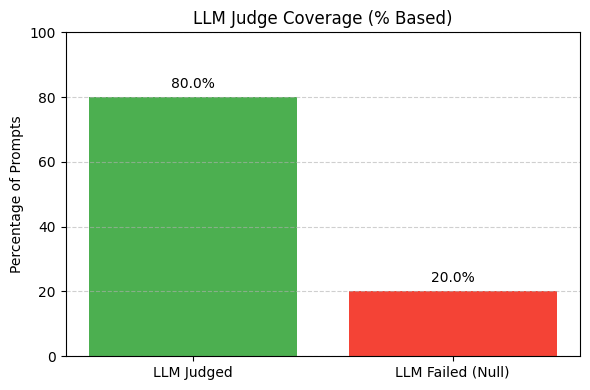

In [ ]:
# Calculate values
total_count = len(merged_olmo2_eval)
null_count = len(null_filtered_df)
non_null_count = total_count - null_count
coverage_pct = non_null_count / total_count * 100
null_pct = null_count / total_count * 100

# Create Bar Chart
labels = ['LLM Judged', 'LLM Failed (Null)']
values = [coverage_pct, null_pct]
colors = ['#4CAF50', '#F44336']  # green / red

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values, color=colors)
plt.ylim(0, 100)
plt.ylabel("Percentage of Prompts")
plt.title("LLM Judge Coverage (% Based)")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add labels on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f"{yval:.1f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### % Ranking Detection Rate

Explain that whether LLM has “detected” a ranking request or not for ranking prompt provided in standardized prompt—even when some prompts are open-ended.

In [ ]:
merged_olmo2_eval.head(20)

,prompt,response,time_taken_sec,prompt_category,row_index,template_version,clarity,relevance,completeness,ranking_detected,ranking_type,brand_score.zara,brand_score.h&m,brand_score.primark,brand_score.burberry
0,Which fashion retail brands are generally considered the best in the UK today?,"In the UK, there are several renowned fashion retail brands that are highly regarded for their quality and style. Some of them include:\n\n1. **Burberry**: Known for its iconic check pattern and a heritage rich in British fashion, Burberry is often ranked among the best high-end fashion brands.\n\n2. **Alexander McQueen**: Renowned for its daring designs and avant-garde approach, Alexander McQueen is celebrated for its influence on global fashion.\n\n3. **Mulberry**: This brand is famous for its exceptional craftsmanship and luxurious leather goods, attracting a loyal following.\n\n4. **J.Crew**: While primarily an American brand, J.Crew has a strong presence in the UK with its classic, contemporary designs that appeal to a wide audience.\n\n5. **H&M**: Although a mass-market retailer, H&M frequently collaborates with high-profile designers and offers trendy, affordable clothing options.\n\n6. **Topshop**: Famous for its edgy street-wear and high-fashion collaborations, Topshop provides a mix of high-street fashion and celebrity influence.\n\n7. **Rebecca Minkoff**: Known for its modern designs and approachable yet fashionable wardrobe, Rebecca Minkoff is a favorite among many style-conscious consumers.\n\n8. **Zara**: As one of the largest fast-fashion retailers in the world, Zara offers trendy, affordable clothing that changes rapidly with the latest fashion trends.\n\n9. **River Island**: With its blend of contemporary styles and classic pieces, River Island provides a competitive offering in the UK high-street market.\n\nThese brands span various price points and fashion sensibilities, catering to a wide range of consumers seeking quality and style in the UK fashion scene.",201.29,Comparison,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Rank Zara, H&M, Primark, and Burberry based on their overall brand presence and public awareness in the fashion industry. Provide justification for the ranking.","Burberry would rank highest in terms of overall brand presence and public awareness in the fashion industry. Here's why:\n\n1. **Legacy and Reputation**: Burberry has been a longstanding brand in the fashion world since its founding in 1856. It has a rich history and a strong reputation, which contributes to its significant brand presence.\n\n2. **Iconic Status**: Burberry is an iconic fashion label known for its iconic check pattern, which has become synonymous with the brand itself. This recognition and widespread use of their design in popular culture and media amplify their public awareness.\n\n3. **Global Expansion**: Burberry has a strong global presence, with stores all over the world, including iconic locations like London's Regent Street. Their international chain stores and online presence further bolster their visibility and reach.\n\n4. **Collaborations and Partnerships**: Burberry collaborates with various celebrities, influencers, and fashion houses, which extends its brand reach and attracts a wider audience.\n\n5. **Luxury Appeal**: While price points might make it more accessible to a certain demographic, Burberry is positioned as a luxury brand, appealing to fashion-forward individuals who appreciate premium craftsmanship and design. Its luxury status enhances its brand perception and recognition.\n\n6. **Marketing and Social Media Presence**: Burberry actively utilizes social media platforms like Instagram, where they showcase their collections, fashion stories, and engage directly with their audience. This modern marketing strategy significantly contributes to their public awareness.\n\nZara, H&M, and Primark, while also very successful in their markets, might rank lower compared to Burberry due to their more focused business

/tmp/ipython-input-67-3797729316.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  flags = merged_olmo2_eval['ranking_detected'].fillna(False).astype(bool)


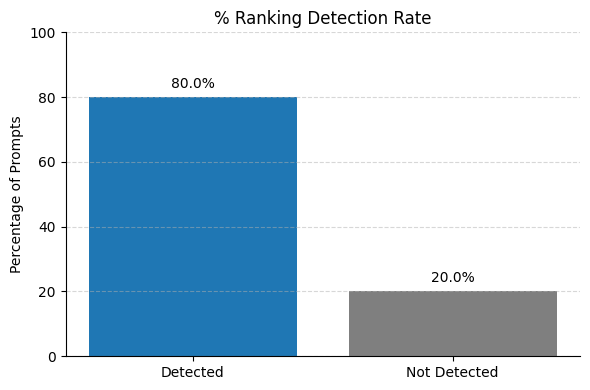

In [ ]:
import matplotlib.pyplot as plt

# Build the boolean flags (NaN → False)
flags = merged_olmo2_eval['ranking_detected'].fillna(False).astype(bool)

# Compute percentages and properly map True/False → labels
detection_pct = (
    flags
    .value_counts(normalize=True)
    .mul(100)
    .rename(index={True: 'Detected', False: 'Not Detected'})
)

# Re‐order so “Detected” appears first
detection_pct = detection_pct.loc[['Detected', 'Not Detected']]

# Plot
colors = ['#1f77b4', '#7f7f7f']  # blue, gray
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(detection_pct.index, detection_pct.values, color=colors)

ax.set_title('% Ranking Detection Rate')
ax.set_ylabel('Percentage of Prompts')
ax.set_ylim(0, 100)
for bar in bars:
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 2,
        f'{bar.get_height():.1f}%',
        ha='center',
        va='bottom'
    )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


<a id="human-evaluation-as-second-checker"></a>  
# 7 Human Evaluation As Second Checker

### Evaluation Strategy: LLM + Human Review

In this project, we **do not manually revise** the null values produced by the LLM in the first evaluation round. Instead, these nulls are **retained and reported** as part of the **LLM coverage metric**, offering transparent insight into the model’s limitations.

This approach preserves a **clear methodological separation**:

- **LLM (Round 1):** Acts as the automated evaluator  
- **Human (Round 2):** Acts as the final reviewer and gold-standard creator

By deferring all human judgments to Round 2, we avoid role overlap and ensure that the **human evaluation covers all prompts**—including those that the LLM failed to assess. This strategy enhances research credibility and supports rigorous post-hoc comparison between LLM and human judgment.


In [ ]:
# After Human review, Load the data
output_path = root / "olmo2_7b_results_human_eval.csv"
human_eval = pd.read_csv(output_path)

In [ ]:
human_eval.head()

,prompt,response,time_taken_sec,prompt_category,row_index,template_version,clarity,relevance,completeness,ranking_detected,ranking_type,brand_score.zara,brand_score.h&m,brand_score.primark,brand_score.burberry
0,Which fashion retail brands are generally considered the best in the UK today?,"In the UK, there are several renowned fashion retail brands that are highly regarded for their quality and style. Some of them include:\n\n1. **Burberry**: Known for its iconic check pattern and a heritage rich in British fashion, Burberry is often ranked among the best high-end fashion brands.\n\n2. **Alexander McQueen**: Renowned for its daring designs and avant-garde approach, Alexander McQueen is celebrated for its influence on global fashion.\n\n3. **Mulberry**: This brand is famous for its exceptional craftsmanship and luxurious leather goods, attracting a loyal following.\n\n4. **J.Crew**: While primarily an American brand, J.Crew has a strong presence in the UK with its classic, contemporary designs that appeal to a wide audience.\n\n5. **H&M**: Although a mass-market retailer, H&M frequently collaborates with high-profile designers and offers trendy, affordable clothing options.\n\n6. **Topshop**: Famous for its edgy street-wear and high-fashion collaborations, Topshop provides a mix of high-street fashion and celebrity influence.\n\n7. **Rebecca Minkoff**: Known for its modern designs and approachable yet fashionable wardrobe, Rebecca Minkoff is a favorite among many style-conscious consumers.\n\n8. **Zara**: As one of the largest fast-fashion retailers in the world, Zara offers trendy, affordable clothing that changes rapidly with the latest fashion trends.\n\n9. **River Island**: With its blend of contemporary styles and classic pieces, River Island provides a competitive offering in the UK high-street market.\n\nThese brands span various price points and fashion sensibilities, catering to a wide range of consumers seeking quality and style in the UK fashion scene.",201.29,Comparison,0,1,1,1.0,1.0,True,explicit,0.4,0.6,0.0,1.0
1,"Rank Zara, H&M, Primark, and Burberry based on their overall brand presence and public awareness in the fashion industry. Provide justification for the ranking.","Burberry would rank highest in terms of overall brand presence and public awareness in the fashion industry. Here's why:\n\n1. **Legacy and Reputation**: Burberry has been a longstanding brand in the fashion world since its founding in 1856. It has a rich history and a strong reputation, which contributes to its significant brand presence.\n\n2. **Iconic Status**: Burberry is an iconic fashion label known for its iconic check pattern, which has become synonymous with the brand itself. This recognition and widespread use of their design in popular culture and media amplify their public awareness.\n\n3. **Global Expansion**: Burberry has a strong global presence, with stores all over the world, including iconic locations like London's Regent Street. Their international chain stores and online presence further bolster their visibility and reach.\n\n4. **Collaborations and Partnerships**: Burberry collaborates with various celebrities, influencers, and fashion houses, which extends its brand reach and attracts a wider audience.\n\n5. **Luxury Appeal**: While price points might make it more accessible to a certain demographic, Burberry is positioned as a luxury brand, appealing to fashion-forward individuals who appreciate premium craftsmanship and design. Its luxury status enhances its brand perception and recognition.\n\n6. **Marketing and Social Media Presence**: Burberry actively utilizes social media platforms like Instagram, where they showcase their collections, fashion stories, and engage directly with their audience. This modern marketing strategy significantly contributes to their public awareness.\n\nZara, H&M, and Primark, while also very successful in their markets, might rank lower compared to Burberry due to their more focused busine

In [ ]:
human_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   prompt                30 non-null     object 
 1   response              30 non-null     object 
 2   time_taken_sec        30 non-null     float64
 3   prompt_category       30 non-null     object 
 4   row_index             30 non-null     int64  
 5   template_version      30 non-null     int64  
 6   clarity               30 non-null     int64  
 7   relevance             30 non-null     float64
 8   completeness          30 non-null     float64
 9   ranking_detected      30 non-null     bool   
 10  ranking_type          30 non-null     object 
 11  brand_score.zara      30 non-null     float64
 12  brand_score.h&m       30 non-null     float64
 13  brand_score.primark   30 non-null     float64
 14  brand_score.burberry  30 non-null     float64
dtypes: bool(1), float64(7), i

## Count rows of  NLP Quality metrics

In [ ]:
clarity_counts      = human_eval["clarity"]      .value_counts(dropna=False).to_frame("count")
relevance_counts    = human_eval["relevance"]    .value_counts(dropna=False).to_frame("count")
completeness_counts = human_eval["completeness"] .value_counts(dropna=False).to_frame("count")

In [ ]:
print("=== Clarity ===")
print(clarity_counts, "\n")

=== Clarity ===
         count
clarity       
1           30 



In [ ]:
print("=== Relevance ===")
print(relevance_counts, "\n")

=== Relevance ===
           count
relevance       
1.0           29
0.5            1 



In [ ]:
print("=== Completeness ===")
print(completeness_counts)

=== Completeness ===
              count
completeness       
1.0              28
0.5               2


In [ ]:
human_eval

,prompt,response,time_taken_sec,prompt_category,row_index,template_version,clarity,relevance,completeness,ranking_detected,ranking_type,brand_score.zara,brand_score.h&m,brand_score.primark,brand_score.burberry
0,Which fashion retail brands are generally considered the best in the UK today?,"In the UK, there are several renowned fashion retail brands that are highly regarded for their quality and style. Some of them include:\n\n1. **Burberry**: Known for its iconic check pattern and a heritage rich in British fashion, Burberry is often ranked among the best high-end fashion brands.\n\n2. **Alexander McQueen**: Renowned for its daring designs and avant-garde approach, Alexander McQueen is celebrated for its influence on global fashion.\n\n3. **Mulberry**: This brand is famous for its exceptional craftsmanship and luxurious leather goods, attracting a loyal following.\n\n4. **J.Crew**: While primarily an American brand, J.Crew has a strong presence in the UK with its classic, contemporary designs that appeal to a wide audience.\n\n5. **H&M**: Although a mass-market retailer, H&M frequently collaborates with high-profile designers and offers trendy, affordable clothing options.\n\n6. **Topshop**: Famous for its edgy street-wear and high-fashion collaborations, Topshop provides a mix of high-street fashion and celebrity influence.\n\n7. **Rebecca Minkoff**: Known for its modern designs and approachable yet fashionable wardrobe, Rebecca Minkoff is a favorite among many style-conscious consumers.\n\n8. **Zara**: As one of the largest fast-fashion retailers in the world, Zara offers trendy, affordable clothing that changes rapidly with the latest fashion trends.\n\n9. **River Island**: With its blend of contemporary styles and classic pieces, River Island provides a competitive offering in the UK high-street market.\n\nThese brands span various price points and fashion sensibilities, catering to a wide range of consumers seeking quality and style in the UK fashion scene.",201.29,Comparison,0,1,1,1.0,1.0,True,explicit,0.4,0.6,0.0,1.0
1,"Rank Zara, H&M, Primark, and Burberry based on their overall brand presence and public awareness in the fashion industry. Provide justification for the ranking.","Burberry would rank highest in terms of overall brand presence and public awareness in the fashion industry. Here's why:\n\n1. **Legacy and Reputation**: Burberry has been a longstanding brand in the fashion world since its founding in 1856. It has a rich history and a strong reputation, which contributes to its significant brand presence.\n\n2. **Iconic Status**: Burberry is an iconic fashion label known for its iconic check pattern, which has become synonymous with the brand itself. This recognition and widespread use of their design in popular culture and media amplify their public awareness.\n\n3. **Global Expansion**: Burberry has a strong global presence, with stores all over the world, including iconic locations like London's Regent Street. Their international chain stores and online presence further bolster their visibility and reach.\n\n4. **Collaborations and Partnerships**: Burberry collaborates with various celebrities, influencers, and fashion houses, which extends its brand reach and attracts a wider audience.\n\n5. **Luxury Appeal**: While price points might make it more accessible to a certain demographic, Burberry is positioned as a luxury brand, appealing to fashion-forward individuals who appreciate premium craftsmanship and design. Its luxury status enhances its brand perception and recognition.\n\n6. **Marketing and Social Media Presence**: Burberry actively utilizes social media platforms like Instagram, where they showcase their collections, fashion stories, and engage directly with their audience. This modern marketing strategy significantly contributes to their public awareness.\n\nZara, H&M, and Primark, while also very successful in their markets, might rank lower compared to Burberry due to their more focused busine

<a id="filling-llm-nulls-via-human-review"></a>  
# 8 Filling LLM Nulls via Human Review

In [ ]:
human_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   prompt                30 non-null     object 
 1   response              30 non-null     object 
 2   time_taken_sec        30 non-null     float64
 3   prompt_category       30 non-null     object 
 4   row_index             30 non-null     int64  
 5   template_version      30 non-null     int64  
 6   clarity               30 non-null     int64  
 7   relevance             30 non-null     float64
 8   completeness          30 non-null     float64
 9   ranking_detected      30 non-null     bool   
 10  ranking_type          30 non-null     object 
 11  brand_score.zara      30 non-null     float64
 12  brand_score.h&m       30 non-null     float64
 13  brand_score.primark   30 non-null     float64
 14  brand_score.burberry  30 non-null     float64
dtypes: bool(1), float64(7), i

In [ ]:
human_eval.head()

,prompt,response,time_taken_sec,prompt_category,row_index,template_version,clarity,relevance,completeness,ranking_detected,ranking_type,brand_score.zara,brand_score.h&m,brand_score.primark,brand_score.burberry
0,Which fashion retail brands are generally considered the best in the UK today?,"In the UK, there are several renowned fashion retail brands that are highly regarded for their quality and style. Some of them include:\n\n1. **Burberry**: Known for its iconic check pattern and a heritage rich in British fashion, Burberry is often ranked among the best high-end fashion brands.\n\n2. **Alexander McQueen**: Renowned for its daring designs and avant-garde approach, Alexander McQueen is celebrated for its influence on global fashion.\n\n3. **Mulberry**: This brand is famous for its exceptional craftsmanship and luxurious leather goods, attracting a loyal following.\n\n4. **J.Crew**: While primarily an American brand, J.Crew has a strong presence in the UK with its classic, contemporary designs that appeal to a wide audience.\n\n5. **H&M**: Although a mass-market retailer, H&M frequently collaborates with high-profile designers and offers trendy, affordable clothing options.\n\n6. **Topshop**: Famous for its edgy street-wear and high-fashion collaborations, Topshop provides a mix of high-street fashion and celebrity influence.\n\n7. **Rebecca Minkoff**: Known for its modern designs and approachable yet fashionable wardrobe, Rebecca Minkoff is a favorite among many style-conscious consumers.\n\n8. **Zara**: As one of the largest fast-fashion retailers in the world, Zara offers trendy, affordable clothing that changes rapidly with the latest fashion trends.\n\n9. **River Island**: With its blend of contemporary styles and classic pieces, River Island provides a competitive offering in the UK high-street market.\n\nThese brands span various price points and fashion sensibilities, catering to a wide range of consumers seeking quality and style in the UK fashion scene.",201.29,Comparison,0,1,1,1.0,1.0,True,explicit,0.4,0.6,0.0,1.0
1,"Rank Zara, H&M, Primark, and Burberry based on their overall brand presence and public awareness in the fashion industry. Provide justification for the ranking.","Burberry would rank highest in terms of overall brand presence and public awareness in the fashion industry. Here's why:\n\n1. **Legacy and Reputation**: Burberry has been a longstanding brand in the fashion world since its founding in 1856. It has a rich history and a strong reputation, which contributes to its significant brand presence.\n\n2. **Iconic Status**: Burberry is an iconic fashion label known for its iconic check pattern, which has become synonymous with the brand itself. This recognition and widespread use of their design in popular culture and media amplify their public awareness.\n\n3. **Global Expansion**: Burberry has a strong global presence, with stores all over the world, including iconic locations like London's Regent Street. Their international chain stores and online presence further bolster their visibility and reach.\n\n4. **Collaborations and Partnerships**: Burberry collaborates with various celebrities, influencers, and fashion houses, which extends its brand reach and attracts a wider audience.\n\n5. **Luxury Appeal**: While price points might make it more accessible to a certain demographic, Burberry is positioned as a luxury brand, appealing to fashion-forward individuals who appreciate premium craftsmanship and design. Its luxury status enhances its brand perception and recognition.\n\n6. **Marketing and Social Media Presence**: Burberry actively utilizes social media platforms like Instagram, where they showcase their collections, fashion stories, and engage directly with their audience. This modern marketing strategy significantly contributes to their public awareness.\n\nZara, H&M, and Primark, while also very successful in their markets, might rank lower compared to Burberry due to their more focused busine

In [ ]:
llm_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   prompt                30 non-null     object 
 1   response              30 non-null     object 
 2   time_taken_sec        30 non-null     float64
 3   prompt_category       30 non-null     object 
 4   row_index             30 non-null     int64  
 5   template_version      24 non-null     float64
 6   clarity               24 non-null     float64
 7   relevance             24 non-null     float64
 8   completeness          24 non-null     float64
 9   ranking_detected      24 non-null     object 
 10  ranking_type          24 non-null     object 
 11  brand_score.zara      24 non-null     float64
 12  brand_score.h&m       24 non-null     float64
 13  brand_score.primark   24 non-null     float64
 14  brand_score.burberry  24 non-null     float64
dtypes: float64(9), int64(1), 

In [ ]:
llm_eval.head()

,prompt,response,time_taken_sec,prompt_category,row_index,template_version,clarity,relevance,completeness,ranking_detected,ranking_type,brand_score.zara,brand_score.h&m,brand_score.primark,brand_score.burberry
0,Which fashion retail brands are generally considered the best in the UK today?,"In the UK, there are several renowned fashion retail brands that are highly regarded for their quality and style. Some of them include:\n\n1. **Burberry**: Known for its iconic check pattern and a heritage rich in British fashion, Burberry is often ranked among the best high-end fashion brands.\n\n2. **Alexander McQueen**: Renowned for its daring designs and avant-garde approach, Alexander McQueen is celebrated for its influence on global fashion.\n\n3. **Mulberry**: This brand is famous for its exceptional craftsmanship and luxurious leather goods, attracting a loyal following.\n\n4. **J.Crew**: While primarily an American brand, J.Crew has a strong presence in the UK with its classic, contemporary designs that appeal to a wide audience.\n\n5. **H&M**: Although a mass-market retailer, H&M frequently collaborates with high-profile designers and offers trendy, affordable clothing options.\n\n6. **Topshop**: Famous for its edgy street-wear and high-fashion collaborations, Topshop provides a mix of high-street fashion and celebrity influence.\n\n7. **Rebecca Minkoff**: Known for its modern designs and approachable yet fashionable wardrobe, Rebecca Minkoff is a favorite among many style-conscious consumers.\n\n8. **Zara**: As one of the largest fast-fashion retailers in the world, Zara offers trendy, affordable clothing that changes rapidly with the latest fashion trends.\n\n9. **River Island**: With its blend of contemporary styles and classic pieces, River Island provides a competitive offering in the UK high-street market.\n\nThese brands span various price points and fashion sensibilities, catering to a wide range of consumers seeking quality and style in the UK fashion scene.",201.29,Comparison,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Rank Zara, H&M, Primark, and Burberry based on their overall brand presence and public awareness in the fashion industry. Provide justification for the ranking.","Burberry would rank highest in terms of overall brand presence and public awareness in the fashion industry. Here's why:\n\n1. **Legacy and Reputation**: Burberry has been a longstanding brand in the fashion world since its founding in 1856. It has a rich history and a strong reputation, which contributes to its significant brand presence.\n\n2. **Iconic Status**: Burberry is an iconic fashion label known for its iconic check pattern, which has become synonymous with the brand itself. This recognition and widespread use of their design in popular culture and media amplify their public awareness.\n\n3. **Global Expansion**: Burberry has a strong global presence, with stores all over the world, including iconic locations like London's Regent Street. Their international chain stores and online presence further bolster their visibility and reach.\n\n4. **Collaborations and Partnerships**: Burberry collaborates with various celebrities, influencers, and fashion houses, which extends its brand reach and attracts a wider audience.\n\n5. **Luxury Appeal**: While price points might make it more accessible to a certain demographic, Burberry is positioned as a luxury brand, appealing to fashion-forward individuals who appreciate premium craftsmanship and design. Its luxury status enhances its brand perception and recognition.\n\n6. **Marketing and Social Media Presence**: Burberry actively utilizes social media platforms like Instagram, where they showcase their collections, fashion stories, and engage directly with their audience. This modern marketing strategy significantly contributes to their public awareness.\n\nZara, H&M, and Primark, while also very successful in their markets, might rank lower compared to Burberry due to their more focused business

In [ ]:
# Identify rows with any nulls in critical columns for replacement
null_mask = llm_eval[[
    "clarity", "relevance", "completeness",
    "ranking_detected", "ranking_type",
    "brand_score.zara", "brand_score.h&m", "brand_score.primark", "brand_score.burberry"
]].isnull().any(axis=1)

In [ ]:
# Use `row_index` as identifier to align and replace only null rows with human-evaluated values
llm_eval.update(human_eval[null_mask])

In [ ]:
llm_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   prompt                30 non-null     object 
 1   response              30 non-null     object 
 2   time_taken_sec        30 non-null     float64
 3   prompt_category       30 non-null     object 
 4   row_index             30 non-null     int64  
 5   template_version      30 non-null     float64
 6   clarity               30 non-null     float64
 7   relevance             30 non-null     float64
 8   completeness          30 non-null     float64
 9   ranking_detected      30 non-null     object 
 10  ranking_type          30 non-null     object 
 11  brand_score.zara      30 non-null     float64
 12  brand_score.h&m       30 non-null     float64
 13  brand_score.primark   30 non-null     float64
 14  brand_score.burberry  30 non-null     float64
dtypes: float64(9), int64(1), 

No null value left in LLM evaluation results

## Save as a checkpoint

**Note:** The code block below might have been intentionally hidden to prevent unintentional multiple downloads during testing of the dataset. This is a best practice to avoid redundant operations that may consume unnecessary resources or lead to duplicate file writes.

In [ ]:
# Save to CSV before finalization
output_path = root / "olmo2_7b_results_final_without_null.csv"
# llm_eval.to_csv(output_path, index=False)

In [ ]:
# Load the data
output_path = root / "olmo2_7b_results_final_without_null.csv"
df_loaded = pd.read_csv(output_path)

<a id="nlp-metrics-agreement-rate-with-average-brand-score-comparison"></a>  
#9 NLP Metrics Agreement Rate with Average Brand Score Comparison

## Reset row_index to start with 1

In [ ]:
llm_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   prompt                30 non-null     object 
 1   response              30 non-null     object 
 2   time_taken_sec        30 non-null     float64
 3   prompt_category       30 non-null     object 
 4   row_index             30 non-null     int64  
 5   template_version      30 non-null     float64
 6   clarity               30 non-null     float64
 7   relevance             30 non-null     float64
 8   completeness          30 non-null     float64
 9   ranking_detected      30 non-null     object 
 10  ranking_type          30 non-null     object 
 11  brand_score.zara      30 non-null     float64
 12  brand_score.h&m       30 non-null     float64
 13  brand_score.primark   30 non-null     float64
 14  brand_score.burberry  30 non-null     float64
dtypes: float64(9), int64(1), 

In [ ]:
human_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   prompt                30 non-null     object 
 1   response              30 non-null     object 
 2   time_taken_sec        30 non-null     float64
 3   prompt_category       30 non-null     object 
 4   row_index             30 non-null     int64  
 5   template_version      30 non-null     int64  
 6   clarity               30 non-null     int64  
 7   relevance             30 non-null     float64
 8   completeness          30 non-null     float64
 9   ranking_detected      30 non-null     bool   
 10  ranking_type          30 non-null     object 
 11  brand_score.zara      30 non-null     float64
 12  brand_score.h&m       30 non-null     float64
 13  brand_score.primark   30 non-null     float64
 14  brand_score.burberry  30 non-null     float64
dtypes: bool(1), float64(7), i

In [ ]:
llm_eval.head()

,prompt,response,time_taken_sec,prompt_category,row_index,template_version,clarity,relevance,completeness,ranking_detected,ranking_type,brand_score.zara,brand_score.h&m,brand_score.primark,brand_score.burberry
0,Which fashion retail brands are generally considered the best in the UK today?,"In the UK, there are several renowned fashion retail brands that are highly regarded for their quality and style. Some of them include:\n\n1. **Burberry**: Known for its iconic check pattern and a heritage rich in British fashion, Burberry is often ranked among the best high-end fashion brands.\n\n2. **Alexander McQueen**: Renowned for its daring designs and avant-garde approach, Alexander McQueen is celebrated for its influence on global fashion.\n\n3. **Mulberry**: This brand is famous for its exceptional craftsmanship and luxurious leather goods, attracting a loyal following.\n\n4. **J.Crew**: While primarily an American brand, J.Crew has a strong presence in the UK with its classic, contemporary designs that appeal to a wide audience.\n\n5. **H&M**: Although a mass-market retailer, H&M frequently collaborates with high-profile designers and offers trendy, affordable clothing options.\n\n6. **Topshop**: Famous for its edgy street-wear and high-fashion collaborations, Topshop provides a mix of high-street fashion and celebrity influence.\n\n7. **Rebecca Minkoff**: Known for its modern designs and approachable yet fashionable wardrobe, Rebecca Minkoff is a favorite among many style-conscious consumers.\n\n8. **Zara**: As one of the largest fast-fashion retailers in the world, Zara offers trendy, affordable clothing that changes rapidly with the latest fashion trends.\n\n9. **River Island**: With its blend of contemporary styles and classic pieces, River Island provides a competitive offering in the UK high-street market.\n\nThese brands span various price points and fashion sensibilities, catering to a wide range of consumers seeking quality and style in the UK fashion scene.",201.29,Comparison,0,1.0,1.0,1.0,1.0,True,explicit,0.4,0.6,0.0,1.0
1,"Rank Zara, H&M, Primark, and Burberry based on their overall brand presence and public awareness in the fashion industry. Provide justification for the ranking.","Burberry would rank highest in terms of overall brand presence and public awareness in the fashion industry. Here's why:\n\n1. **Legacy and Reputation**: Burberry has been a longstanding brand in the fashion world since its founding in 1856. It has a rich history and a strong reputation, which contributes to its significant brand presence.\n\n2. **Iconic Status**: Burberry is an iconic fashion label known for its iconic check pattern, which has become synonymous with the brand itself. This recognition and widespread use of their design in popular culture and media amplify their public awareness.\n\n3. **Global Expansion**: Burberry has a strong global presence, with stores all over the world, including iconic locations like London's Regent Street. Their international chain stores and online presence further bolster their visibility and reach.\n\n4. **Collaborations and Partnerships**: Burberry collaborates with various celebrities, influencers, and fashion houses, which extends its brand reach and attracts a wider audience.\n\n5. **Luxury Appeal**: While price points might make it more accessible to a certain demographic, Burberry is positioned as a luxury brand, appealing to fashion-forward individuals who appreciate premium craftsmanship and design. Its luxury status enhances its brand perception and recognition.\n\n6. **Marketing and Social Media Presence**: Burberry actively utilizes social media platforms like Instagram, where they showcase their collections, fashion stories, and engage directly with their audience. This modern marketing strategy significantly contributes to their public awareness.\n\nZara, H&M, and Primark, while also very successful in their markets, might rank lower compared to Burberry due to their more focused bu

In [ ]:
human_eval.head()

,prompt,response,time_taken_sec,prompt_category,row_index,template_version,clarity,relevance,completeness,ranking_detected,ranking_type,brand_score.zara,brand_score.h&m,brand_score.primark,brand_score.burberry
0,Which fashion retail brands are generally considered the best in the UK today?,"In the UK, there are several renowned fashion retail brands that are highly regarded for their quality and style. Some of them include:\n\n1. **Burberry**: Known for its iconic check pattern and a heritage rich in British fashion, Burberry is often ranked among the best high-end fashion brands.\n\n2. **Alexander McQueen**: Renowned for its daring designs and avant-garde approach, Alexander McQueen is celebrated for its influence on global fashion.\n\n3. **Mulberry**: This brand is famous for its exceptional craftsmanship and luxurious leather goods, attracting a loyal following.\n\n4. **J.Crew**: While primarily an American brand, J.Crew has a strong presence in the UK with its classic, contemporary designs that appeal to a wide audience.\n\n5. **H&M**: Although a mass-market retailer, H&M frequently collaborates with high-profile designers and offers trendy, affordable clothing options.\n\n6. **Topshop**: Famous for its edgy street-wear and high-fashion collaborations, Topshop provides a mix of high-street fashion and celebrity influence.\n\n7. **Rebecca Minkoff**: Known for its modern designs and approachable yet fashionable wardrobe, Rebecca Minkoff is a favorite among many style-conscious consumers.\n\n8. **Zara**: As one of the largest fast-fashion retailers in the world, Zara offers trendy, affordable clothing that changes rapidly with the latest fashion trends.\n\n9. **River Island**: With its blend of contemporary styles and classic pieces, River Island provides a competitive offering in the UK high-street market.\n\nThese brands span various price points and fashion sensibilities, catering to a wide range of consumers seeking quality and style in the UK fashion scene.",201.29,Comparison,0,1,1,1.0,1.0,True,explicit,0.4,0.6,0.0,1.0
1,"Rank Zara, H&M, Primark, and Burberry based on their overall brand presence and public awareness in the fashion industry. Provide justification for the ranking.","Burberry would rank highest in terms of overall brand presence and public awareness in the fashion industry. Here's why:\n\n1. **Legacy and Reputation**: Burberry has been a longstanding brand in the fashion world since its founding in 1856. It has a rich history and a strong reputation, which contributes to its significant brand presence.\n\n2. **Iconic Status**: Burberry is an iconic fashion label known for its iconic check pattern, which has become synonymous with the brand itself. This recognition and widespread use of their design in popular culture and media amplify their public awareness.\n\n3. **Global Expansion**: Burberry has a strong global presence, with stores all over the world, including iconic locations like London's Regent Street. Their international chain stores and online presence further bolster their visibility and reach.\n\n4. **Collaborations and Partnerships**: Burberry collaborates with various celebrities, influencers, and fashion houses, which extends its brand reach and attracts a wider audience.\n\n5. **Luxury Appeal**: While price points might make it more accessible to a certain demographic, Burberry is positioned as a luxury brand, appealing to fashion-forward individuals who appreciate premium craftsmanship and design. Its luxury status enhances its brand perception and recognition.\n\n6. **Marketing and Social Media Presence**: Burberry actively utilizes social media platforms like Instagram, where they showcase their collections, fashion stories, and engage directly with their audience. This modern marketing strategy significantly contributes to their public awareness.\n\nZara, H&M, and Primark, while also very successful in their markets, might rank lower compared to Burberry due to their more focused busine

In [ ]:
for df in (llm_eval, human_eval):
    # make the real index 1-based
    df.index = pd.RangeIndex(start=1, stop=len(df) + 1, step=1)

    # synchronise the row_index column with the new index
    # If the column doesn't exist yet, this will create it; if it exists, it will overwrite it.
    df['row_index'] = df.index

In [ ]:
human_eval.head()

,prompt,response,time_taken_sec,prompt_category,row_index,template_version,clarity,relevance,completeness,ranking_detected,ranking_type,brand_score.zara,brand_score.h&m,brand_score.primark,brand_score.burberry
1,Which fashion retail brands are generally considered the best in the UK today?,"In the UK, there are several renowned fashion retail brands that are highly regarded for their quality and style. Some of them include:\n\n1. **Burberry**: Known for its iconic check pattern and a heritage rich in British fashion, Burberry is often ranked among the best high-end fashion brands.\n\n2. **Alexander McQueen**: Renowned for its daring designs and avant-garde approach, Alexander McQueen is celebrated for its influence on global fashion.\n\n3. **Mulberry**: This brand is famous for its exceptional craftsmanship and luxurious leather goods, attracting a loyal following.\n\n4. **J.Crew**: While primarily an American brand, J.Crew has a strong presence in the UK with its classic, contemporary designs that appeal to a wide audience.\n\n5. **H&M**: Although a mass-market retailer, H&M frequently collaborates with high-profile designers and offers trendy, affordable clothing options.\n\n6. **Topshop**: Famous for its edgy street-wear and high-fashion collaborations, Topshop provides a mix of high-street fashion and celebrity influence.\n\n7. **Rebecca Minkoff**: Known for its modern designs and approachable yet fashionable wardrobe, Rebecca Minkoff is a favorite among many style-conscious consumers.\n\n8. **Zara**: As one of the largest fast-fashion retailers in the world, Zara offers trendy, affordable clothing that changes rapidly with the latest fashion trends.\n\n9. **River Island**: With its blend of contemporary styles and classic pieces, River Island provides a competitive offering in the UK high-street market.\n\nThese brands span various price points and fashion sensibilities, catering to a wide range of consumers seeking quality and style in the UK fashion scene.",201.29,Comparison,1,1,1,1.0,1.0,True,explicit,0.4,0.6,0.0,1.0
2,"Rank Zara, H&M, Primark, and Burberry based on their overall brand presence and public awareness in the fashion industry. Provide justification for the ranking.","Burberry would rank highest in terms of overall brand presence and public awareness in the fashion industry. Here's why:\n\n1. **Legacy and Reputation**: Burberry has been a longstanding brand in the fashion world since its founding in 1856. It has a rich history and a strong reputation, which contributes to its significant brand presence.\n\n2. **Iconic Status**: Burberry is an iconic fashion label known for its iconic check pattern, which has become synonymous with the brand itself. This recognition and widespread use of their design in popular culture and media amplify their public awareness.\n\n3. **Global Expansion**: Burberry has a strong global presence, with stores all over the world, including iconic locations like London's Regent Street. Their international chain stores and online presence further bolster their visibility and reach.\n\n4. **Collaborations and Partnerships**: Burberry collaborates with various celebrities, influencers, and fashion houses, which extends its brand reach and attracts a wider audience.\n\n5. **Luxury Appeal**: While price points might make it more accessible to a certain demographic, Burberry is positioned as a luxury brand, appealing to fashion-forward individuals who appreciate premium craftsmanship and design. Its luxury status enhances its brand perception and recognition.\n\n6. **Marketing and Social Media Presence**: Burberry actively utilizes social media platforms like Instagram, where they showcase their collections, fashion stories, and engage directly with their audience. This modern marketing strategy significantly contributes to their public awareness.\n\nZara, H&M, and Primark, while also very successful in their markets, might rank lower compared to Burberry due to their more focused busine

In [ ]:
llm_eval.head()

,prompt,response,time_taken_sec,prompt_category,row_index,template_version,clarity,relevance,completeness,ranking_detected,ranking_type,brand_score.zara,brand_score.h&m,brand_score.primark,brand_score.burberry
1,Which fashion retail brands are generally considered the best in the UK today?,"In the UK, there are several renowned fashion retail brands that are highly regarded for their quality and style. Some of them include:\n\n1. **Burberry**: Known for its iconic check pattern and a heritage rich in British fashion, Burberry is often ranked among the best high-end fashion brands.\n\n2. **Alexander McQueen**: Renowned for its daring designs and avant-garde approach, Alexander McQueen is celebrated for its influence on global fashion.\n\n3. **Mulberry**: This brand is famous for its exceptional craftsmanship and luxurious leather goods, attracting a loyal following.\n\n4. **J.Crew**: While primarily an American brand, J.Crew has a strong presence in the UK with its classic, contemporary designs that appeal to a wide audience.\n\n5. **H&M**: Although a mass-market retailer, H&M frequently collaborates with high-profile designers and offers trendy, affordable clothing options.\n\n6. **Topshop**: Famous for its edgy street-wear and high-fashion collaborations, Topshop provides a mix of high-street fashion and celebrity influence.\n\n7. **Rebecca Minkoff**: Known for its modern designs and approachable yet fashionable wardrobe, Rebecca Minkoff is a favorite among many style-conscious consumers.\n\n8. **Zara**: As one of the largest fast-fashion retailers in the world, Zara offers trendy, affordable clothing that changes rapidly with the latest fashion trends.\n\n9. **River Island**: With its blend of contemporary styles and classic pieces, River Island provides a competitive offering in the UK high-street market.\n\nThese brands span various price points and fashion sensibilities, catering to a wide range of consumers seeking quality and style in the UK fashion scene.",201.29,Comparison,1,1.0,1.0,1.0,1.0,True,explicit,0.4,0.6,0.0,1.0
2,"Rank Zara, H&M, Primark, and Burberry based on their overall brand presence and public awareness in the fashion industry. Provide justification for the ranking.","Burberry would rank highest in terms of overall brand presence and public awareness in the fashion industry. Here's why:\n\n1. **Legacy and Reputation**: Burberry has been a longstanding brand in the fashion world since its founding in 1856. It has a rich history and a strong reputation, which contributes to its significant brand presence.\n\n2. **Iconic Status**: Burberry is an iconic fashion label known for its iconic check pattern, which has become synonymous with the brand itself. This recognition and widespread use of their design in popular culture and media amplify their public awareness.\n\n3. **Global Expansion**: Burberry has a strong global presence, with stores all over the world, including iconic locations like London's Regent Street. Their international chain stores and online presence further bolster their visibility and reach.\n\n4. **Collaborations and Partnerships**: Burberry collaborates with various celebrities, influencers, and fashion houses, which extends its brand reach and attracts a wider audience.\n\n5. **Luxury Appeal**: While price points might make it more accessible to a certain demographic, Burberry is positioned as a luxury brand, appealing to fashion-forward individuals who appreciate premium craftsmanship and design. Its luxury status enhances its brand perception and recognition.\n\n6. **Marketing and Social Media Presence**: Burberry actively utilizes social media platforms like Instagram, where they showcase their collections, fashion stories, and engage directly with their audience. This modern marketing strategy significantly contributes to their public awareness.\n\nZara, H&M, and Primark, while also very successful in their markets, might rank lower compared to Burberry due to their more focused bu

## By prompt question

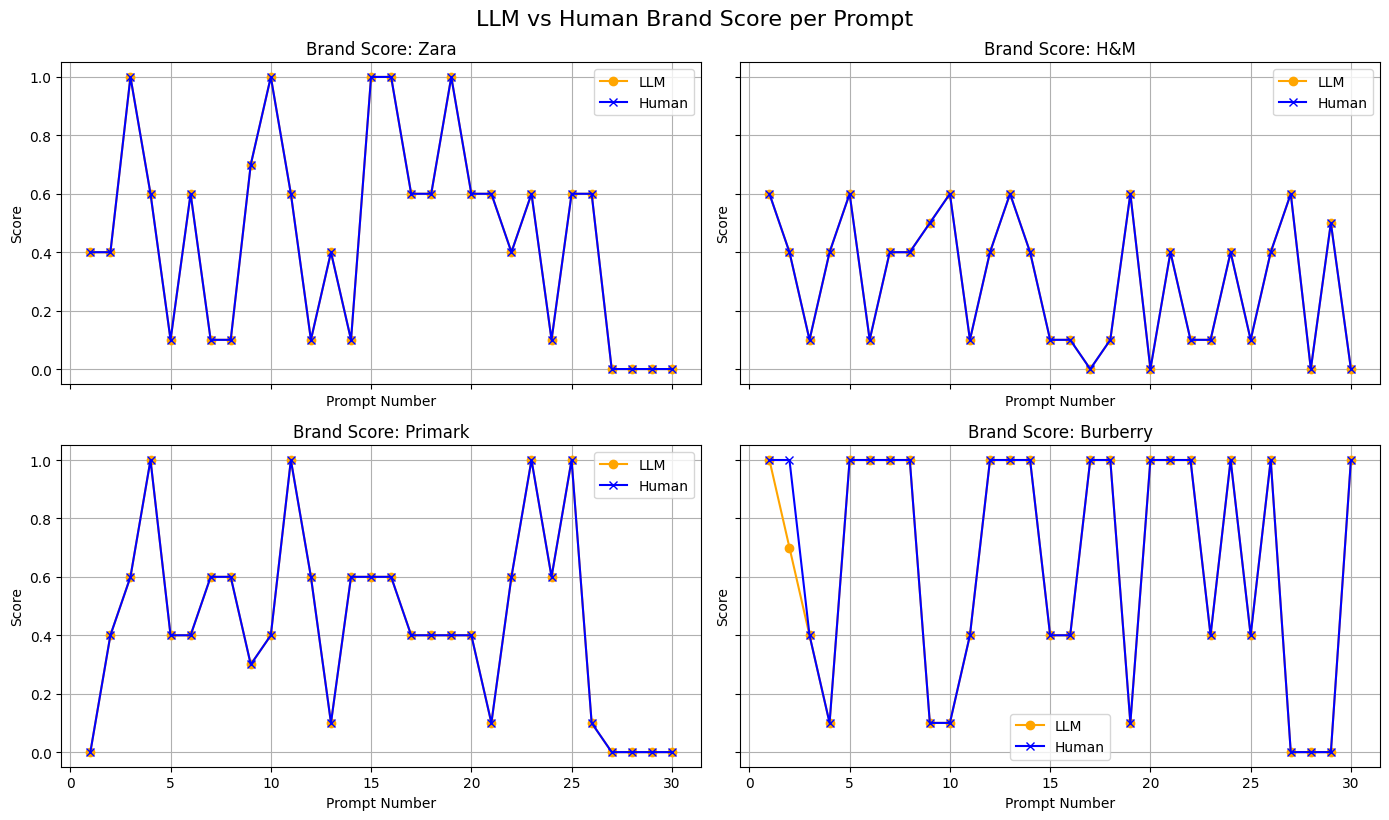

In [ ]:
brands = ['zara', 'h&m', 'primark', 'burberry']
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, brand in enumerate(brands):
    llm_scores   = llm_eval[f'brand_score.{brand}']
    human_scores = human_eval[f'brand_score.{brand}']
    x_vals       = llm_scores.index         # <-- use the index directly, no +1

    axes[i].plot(x_vals, llm_scores,   label='LLM',   marker='o', color='orange')
    axes[i].plot(x_vals, human_scores, label='Human', marker='x', color='blue')

    axes[i].set_title(f"Brand Score: {brand.title()}")
    axes[i].set_xlabel("Prompt Number")
    axes[i].set_ylabel("Score")
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.suptitle("LLM vs Human Brand Score per Prompt", fontsize=16, y=1.02)
plt.show()

## Disagreed prompt question

In [ ]:
# Define brand score columns
brand_cols = [f'brand_score.{b}' for b in ['zara', 'h&m', 'primark', 'burberry']]

# Calculate difference mask where any brand score differs between LLM and Human (after rounding)
diff_mask = (llm_eval[brand_cols].round(2) != human_eval[brand_cols].round(2)).any(axis=1)

In [ ]:
# Exclude 'time_taken_sec' from the merged output
exclude_cols = ['time_taken_sec']
meta_cols = [col for col in llm_eval.columns if col not in brand_cols + exclude_cols]

# Combine all metadata from LLM (e.g. prompt, response, etc.)
meta_df = llm_eval.loc[diff_mask, meta_cols]

# Group brand scores side by side by brand for visual comparison
merged_scores = pd.concat(
    [llm_eval.loc[diff_mask, brand_cols].add_prefix('llm_'),
     human_eval.loc[diff_mask, brand_cols].add_prefix('human_')],
    axis=1
)

# Reorder columns: place each LLM-Human brand pair next to each other
ordered_cols = []
for b in ['zara', 'h&m', 'primark', 'burberry']:
    ordered_cols += [f"llm_brand_score.{b}", f"human_brand_score.{b}"]

# Concatenate everything into final disagreement frame
disagreement_df = pd.concat([meta_df.reset_index(), merged_scores[ordered_cols].reset_index(drop=True)], axis=1)

n_rows = disagreement_df.shape[0]
print(f"Rows in head(20): {n_rows}")

Rows in head(20): 1


In [ ]:
disagreement_df.head(20)

,index,prompt,response,prompt_category,row_index,template_version,clarity,relevance,completeness,ranking_detected,ranking_type,llm_brand_score.zara,human_brand_score.zara,llm_brand_score.h&m,human_brand_score.h&m,llm_brand_score.primark,human_brand_score.primark,llm_brand_score.burberry,human_brand_score.burberry
0,2,"Rank Zara, H&M, Primark, and Burberry based on their overall brand presence and public awareness in the fashion industry. Provide justification for the ranking.","Burberry would rank highest in terms of overall brand presence and public awareness in the fashion industry. Here's why:\n\n1. **Legacy and Reputation**: Burberry has been a longstanding brand in the fashion world since its founding in 1856. It has a rich history and a strong reputation, which contributes to its significant brand presence.\n\n2. **Iconic Status**: Burberry is an iconic fashion label known for its iconic check pattern, which has become synonymous with the brand itself. This recognition and widespread use of their design in popular culture and media amplify their public awareness.\n\n3. **Global Expansion**: Burberry has a strong global presence, with stores all over the world, including iconic locations like London's Regent Street. Their international chain stores and online presence further bolster their visibility and reach.\n\n4. **Collaborations and Partnerships**: Burberry collaborates with various celebrities, influencers, and fashion houses, which extends its brand reach and attracts a wider audience.\n\n5. **Luxury Appeal**: While price points might make it more accessible to a certain demographic, Burberry is positioned as a luxury brand, appealing to fashion-forward individuals who appreciate premium craftsmanship and design. Its luxury status enhances its brand perception and recognition.\n\n6. **Marketing and Social Media Presence**: Burberry actively utilizes social media platforms like Instagram, where they showcase their collections, fashion stories, and engage directly with their audience. This modern marketing strategy significantly contributes to their public awareness.\n\nZara, H&M, and Primark, while also very successful in their markets, might rank lower compared to Burberry due to their more focused business model on fast fashion at affordable prices, which caters to a different demographic and market segment than the luxury appeal of Burberry. They are certainly influential within their niches but do not carry the same level of international prestige and luxury branding associated with Burberry.",Comparison,2,1.0,1.0,1.0,1.0,True,soft_rank,0.4,0.4,0.4,0.4,0.4,0.4,0.7,1.0


In [ ]:
# Create a dictionary to hold deltas
delta_data = {}

# Compute absolute difference between LLM and Human for each brand
for b in ['zara', 'h&m', 'primark', 'burberry']:
    col_llm = f"llm_brand_score.{b}"
    col_human = f"human_brand_score.{b}"
    delta = (disagreement_df[col_llm] - disagreement_df[col_human]).abs()
    delta_data[b] = delta

# Convert to DataFrame
delta_df = pd.DataFrame(delta_data)

# Add sum column for total change per row (optional)
delta_df["sum_delta"] = delta_df.sum(axis=1)

# Compute total delta per brand
delta_summary = delta_df.sum().to_frame(name="total_change")

# Display both detailed and summary
print("Detailed Delta per Row:")
display(delta_df)

print("Summary Delta per Brand:")
display(delta_summary)

Detailed Delta per Row:


,zara,h&m,primark,burberry,sum_delta
0,0.0,0.0,0.0,0.3,0.3


Summary Delta per Brand:


,total_change
zara,0.0
h&m,0.0
primark,0.0
burberry,0.3
sum_delta,0.3


### Partial disagreement rate (only mismatch row)

In [ ]:
# Total number of mismatched rows × 4 brands × max per-brand diff (1.0)
max_possible_delta = len(delta_df) * 4 * 1.0

# Normalize total change to get % disagreement
normalized_delta = delta_summary.loc['sum_delta', 'total_change'] / max_possible_delta

print(f"Total Delta = {delta_summary.loc['sum_delta', 'total_change']:.2f}")
print(f"Max Possible Delta = {max_possible_delta}")
print(f"Normalized Delta (% Disagreement) = {normalized_delta:.2%}")

Total Delta = 0.30
Max Possible Delta = 4.0
Normalized Delta (% Disagreement) = 7.50%


### Overall disagreement rate (every prompt)

In [ ]:
# Total number of prompts × 4 brands × max per-brand diff (1.0)
max_possible_delta = 30 * 4 * 1.0

# Normalize based on full prompt set (not just mismatches)
normalized_delta = delta_summary.loc['sum_delta', 'total_change'] / max_possible_delta

print(f"Total Delta = {delta_summary.loc['sum_delta', 'total_change']:.2f}")
print(f"Max Possible Delta = {max_possible_delta}")
print(f"Normalized Delta over all prompts (% Disagreement) = {normalized_delta:.2%}")

Total Delta = 0.30
Max Possible Delta = 120.0
Normalized Delta over all prompts (% Disagreement) = 0.25%


## By general NLP quality metrics

## Average scores of NLP quality metrics after replacing null

In [ ]:
# Ensure the relevant columns are numeric (in case of accidental string types after update)
llm_eval[["clarity", "relevance", "completeness"]] = llm_eval[["clarity", "relevance", "completeness"]].astype(float)

In [ ]:
# Calculate average scores for all clarity-related metrics after replacement
avg_scores = llm_eval[["clarity", "relevance", "completeness"]].mean()

In [ ]:
# Print key results
print("Average Scores (All Prompts, After Replacing Nulls):\n", avg_scores.round(2))

Average Scores (All Prompts, After Replacing Nulls):
 clarity         1.00
relevance       0.98
completeness    0.97
dtype: float64


In [ ]:
# Average Scores (All Prompts, After Replacing Nulls)
avg_scores_rounded = avg_scores.round(2)
print("Average Scores (All Prompts, After Replacing Nulls):")
display(avg_scores_rounded.to_frame(name='Average Score'))

Average Scores (All Prompts, After Replacing Nulls):


,Average Score
clarity,1.00
relevance,0.98
completeness,0.97


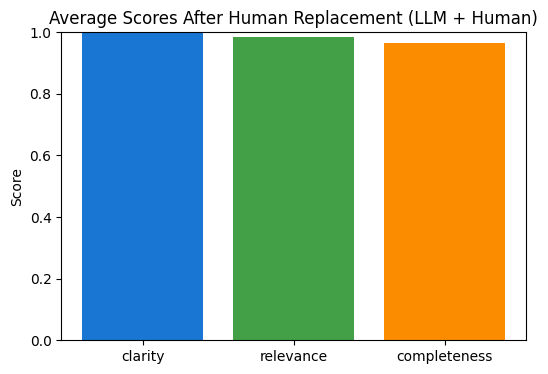

In [ ]:
# Plot bar chart showing average score per dimension
plt.figure(figsize=(6, 4))
plt.bar(avg_scores.index, avg_scores.values, color=['#1976d2', '#43a047', '#fb8c00'])
plt.title("Average Scores After Human Replacement (LLM + Human)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

In [ ]:
cols = ['clarity', 'relevance', 'completeness']

# Recalculate the mask to match updated DataFrame index
null_mask = (
    llm_eval[cols].isna().any(axis=1) |
    human_eval[cols].isna().any(axis=1)
)

valid = ~null_mask

llm_general_nlp   = llm_eval.loc[valid, cols]
human_general_nlp = human_eval.loc[valid, cols]

matches_general_nlp   = llm_general_nlp.round(2) == human_general_nlp.round(2)
agreement_general_nlp = matches_general_nlp.mean().round(2)      # per dimension
overall_general_nlp   = matches_general_nlp.values.mean().round(2)  # overall

print("Agreement rate for general NLP dimensions:")
display(agreement_general_nlp.to_frame(name='Agreement'))

print(f"Overall agreement (all general NLP dims): {overall_general_nlp}\n")

Agreement rate for general NLP dimensions:


,Agreement
clarity,1.0
relevance,1.0
completeness,1.0


Overall agreement (all general NLP dims): 1.0



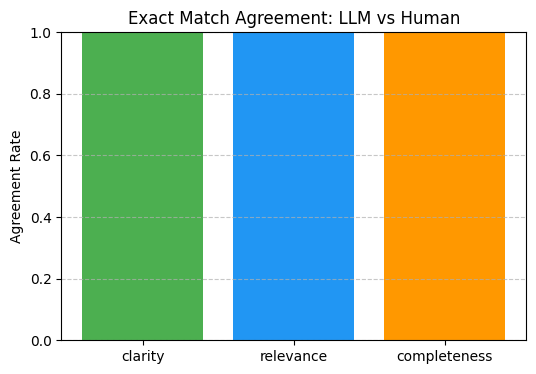

In [ ]:
if 'row_index' not in llm_eval.columns:
    llm_eval['row_index'] = llm_eval.index

if 'row_index' not in human_eval.columns:
    human_eval['row_index'] = human_eval.index

# LLM cannot judge if any of the 3 fields is null
null_mask = llm_eval[['clarity', 'relevance', 'completeness']].isnull().any(axis=1)

valid_rows = ~null_mask

llm_eval = llm_eval.set_index('row_index')
human_eval = human_eval.set_index('row_index')


llm_valid = llm_eval.loc[valid_rows]
human_valid = human_eval.loc[valid_rows]


agreement_matrix = (llm_valid[['clarity', 'relevance', 'completeness']].round(2) ==
                    human_valid[['clarity', 'relevance', 'completeness']].round(2))
agreement_scores = agreement_matrix.mean().round(3)

plt.figure(figsize=(6, 4))
colors = ['#4caf50', '#2196f3', '#ff9800']  # green, blue, orange
plt.bar(agreement_scores.index, agreement_scores.values, color=colors)
plt.title("Exact Match Agreement: LLM vs Human")
plt.ylabel("Agreement Rate")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Difference in NLP Quality (LLM – Human)

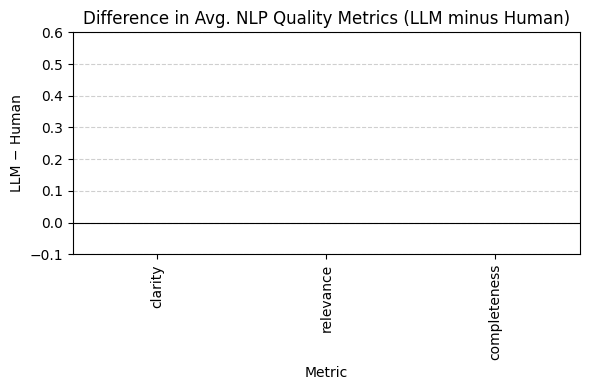

In [ ]:
metrics = ['clarity', 'relevance', 'completeness']

llm_avg    = llm_eval[metrics].mean()
human_avg  = human_eval[metrics].mean()
metric_diff = llm_avg - human_avg          # LLM minus Human
metric_diff.name = "Diff"                  # just for nice axis label

# three distinct colors, one per metric
colors = ["#1f77b4",  # blue   – clarity
          "#2ca02c",  # green  – relevance
          "#ff7f0e"]  # orange – completeness

fig, ax = plt.subplots(figsize=(6, 4))

metric_diff.plot.bar(ax=ax, color=colors)

# reference line at 0
ax.axhline(0, color="black", linewidth=0.8)

# dashed y-grid for readability
ax.grid(axis="y", linestyle="--", alpha=0.6)

# tweak y-axis limits if your diffs exceed this range
ax.set_ylim(-0.1, 0.6)

# axis labels and title
ax.set_xlabel("Metric")
ax.set_ylabel("LLM − Human")
ax.set_title("Difference in Avg. NLP Quality Metrics (LLM minus Human)")

plt.tight_layout()
plt.show()

## By Brand Score metrics

### LLM evaluation

In [ ]:
llm_eval.head()

,prompt,response,time_taken_sec,prompt_category,template_version,clarity,relevance,completeness,ranking_detected,ranking_type,brand_score.zara,brand_score.h&m,brand_score.primark,brand_score.burberry
row_index,,,,,,,,,,,,,,
1,Which fashion retail brands are generally considered the best in the UK today?,"In the UK, there are several renowned fashion retail brands that are highly regarded for their quality and style. Some of them include:\n\n1. **Burberry**: Known for its iconic check pattern and a heritage rich in British fashion, Burberry is often ranked among the best high-end fashion brands.\n\n2. **Alexander McQueen**: Renowned for its daring designs and avant-garde approach, Alexander McQueen is celebrated for its influence on global fashion.\n\n3. **Mulberry**: This brand is famous for its exceptional craftsmanship and luxurious leather goods, attracting a loyal following.\n\n4. **J.Crew**: While primarily an American brand, J.Crew has a strong presence in the UK with its classic, contemporary designs that appeal to a wide audience.\n\n5. **H&M**: Although a mass-market retailer, H&M frequently collaborates with high-profile designers and offers trendy, affordable clothing options.\n\n6. **Topshop**: Famous for its edgy street-wear and high-fashion collaborations, Topshop provides a mix of high-street fashion and celebrity influence.\n\n7. **Rebecca Minkoff**: Known for its modern designs and approachable yet fashionable wardrobe, Rebecca Minkoff is a favorite among many style-conscious consumers.\n\n8. **Zara**: As one of the largest fast-fashion retailers in the world, Zara offers trendy, affordable clothing that changes rapidly with the latest fashion trends.\n\n9. **River Island**: With its blend of contemporary styles and classic pieces, River Island provides a competitive offering in the UK high-street market.\n\nThese brands span various price points and fashion sensibilities, catering to a wide range of consumers seeking quality and style in the UK fashion scene.",201.29,Comparison,1.0,1.0,1.0,1.0,True,explicit,0.4,0.6,0.0,1.0
2,"Rank Zara, H&M, Primark, and Burberry based on their overall brand presence and public awareness in the fashion industry. Provide justification for the ranking.","Burberry would rank highest in terms of overall brand presence and public awareness in the fashion industry. Here's why:\n\n1. **Legacy and Reputation**: Burberry has been a longstanding brand in the fashion world since its founding in 1856. It has a rich history and a strong reputation, which contributes to its significant brand presence.\n\n2. **Iconic Status**: Burberry is an iconic fashion label known for its iconic check pattern, which has become synonymous with the brand itself. This recognition and widespread use of their design in popular culture and media amplify their public awareness.\n\n3. **Global Expansion**: Burberry has a strong global presence, with stores all over the world, including iconic locations like London's Regent Street. Their international chain stores and online presence further bolster their visibility and reach.\n\n4. **Collaborations and Partnerships**: Burberry collaborates with various celebrities, influencers, and fashion houses, which extends its brand reach and attracts a wider audience.\n\n5. **Luxury Appeal**: While price points might make it more accessible to a certain demographic, Burberry is positioned as a luxury brand, appealing to fashion-forward individuals who appreciate premium craftsmanship and design. Its luxury status enhances its brand perception and recognition.\n\n6. **Marketing and Social Media Presence**: Burberry actively utilizes social media platforms like Instagram, where they showcase their collections, fashion stories, and engage directly with their audience. This modern marketing strategy significantly contributes to their public awareness.\n\nZara, H&M, and Primark, while also very successful in their markets, might rank lower compared to Burberry due to their mor

In [ ]:
llm_eval.describe().round(2)

,time_taken_sec,template_version,clarity,relevance,completeness,brand_score.zara,brand_score.h&m,brand_score.primark,brand_score.burberry
count,30.00,30.0,30.0,30.00,30.00,30.00,30.00,30.00,30.00
mean,206.62,1.0,1.0,0.98,0.97,0.46,0.30,0.44,0.65
std,63.65,0.0,0.0,0.09,0.13,0.34,0.22,0.31,0.41
min,69.24,1.0,1.0,0.50,0.50,0.00,0.00,0.00,0.00
25%,180.24,1.0,1.0,1.00,1.00,0.10,0.10,0.15,0.40
50%,208.63,1.0,1.0,1.00,1.00,0.60,0.40,0.40,1.00
75%,242.15,1.0,1.0,1.00,1.00,0.60,0.48,0.60,1.00
max,343.24,1.0,1.0,1.00,1.00,1.00,0.60,1.00,1.00


In [ ]:
# Calculate the mean score for each brand in the LLM evaluation
llm_avg = (
    llm_eval[['brand_score.zara', 'brand_score.h&m', 'brand_score.primark', 'brand_score.burberry']]
    .mean()
    .round(2)
    .rename({
        'brand_score.zara': 'Zara',
        'brand_score.h&m': 'H&M',
        'brand_score.primark': 'Primark',
        'brand_score.burberry': 'Burberry'
    })
)

print("LLM average brand scores:")
display(llm_avg.to_frame(name='LLM_avg_score'))

LLM average brand scores:


,LLM_avg_score
Zara,0.46
H&M,0.30
Primark,0.44
Burberry,0.65


### Human Evaluation

In [ ]:
human_eval.head()

,prompt,response,time_taken_sec,prompt_category,template_version,clarity,relevance,completeness,ranking_detected,ranking_type,brand_score.zara,brand_score.h&m,brand_score.primark,brand_score.burberry
row_index,,,,,,,,,,,,,,
1,Which fashion retail brands are generally considered the best in the UK today?,"In the UK, there are several renowned fashion retail brands that are highly regarded for their quality and style. Some of them include:\n\n1. **Burberry**: Known for its iconic check pattern and a heritage rich in British fashion, Burberry is often ranked among the best high-end fashion brands.\n\n2. **Alexander McQueen**: Renowned for its daring designs and avant-garde approach, Alexander McQueen is celebrated for its influence on global fashion.\n\n3. **Mulberry**: This brand is famous for its exceptional craftsmanship and luxurious leather goods, attracting a loyal following.\n\n4. **J.Crew**: While primarily an American brand, J.Crew has a strong presence in the UK with its classic, contemporary designs that appeal to a wide audience.\n\n5. **H&M**: Although a mass-market retailer, H&M frequently collaborates with high-profile designers and offers trendy, affordable clothing options.\n\n6. **Topshop**: Famous for its edgy street-wear and high-fashion collaborations, Topshop provides a mix of high-street fashion and celebrity influence.\n\n7. **Rebecca Minkoff**: Known for its modern designs and approachable yet fashionable wardrobe, Rebecca Minkoff is a favorite among many style-conscious consumers.\n\n8. **Zara**: As one of the largest fast-fashion retailers in the world, Zara offers trendy, affordable clothing that changes rapidly with the latest fashion trends.\n\n9. **River Island**: With its blend of contemporary styles and classic pieces, River Island provides a competitive offering in the UK high-street market.\n\nThese brands span various price points and fashion sensibilities, catering to a wide range of consumers seeking quality and style in the UK fashion scene.",201.29,Comparison,1,1,1.0,1.0,True,explicit,0.4,0.6,0.0,1.0
2,"Rank Zara, H&M, Primark, and Burberry based on their overall brand presence and public awareness in the fashion industry. Provide justification for the ranking.","Burberry would rank highest in terms of overall brand presence and public awareness in the fashion industry. Here's why:\n\n1. **Legacy and Reputation**: Burberry has been a longstanding brand in the fashion world since its founding in 1856. It has a rich history and a strong reputation, which contributes to its significant brand presence.\n\n2. **Iconic Status**: Burberry is an iconic fashion label known for its iconic check pattern, which has become synonymous with the brand itself. This recognition and widespread use of their design in popular culture and media amplify their public awareness.\n\n3. **Global Expansion**: Burberry has a strong global presence, with stores all over the world, including iconic locations like London's Regent Street. Their international chain stores and online presence further bolster their visibility and reach.\n\n4. **Collaborations and Partnerships**: Burberry collaborates with various celebrities, influencers, and fashion houses, which extends its brand reach and attracts a wider audience.\n\n5. **Luxury Appeal**: While price points might make it more accessible to a certain demographic, Burberry is positioned as a luxury brand, appealing to fashion-forward individuals who appreciate premium craftsmanship and design. Its luxury status enhances its brand perception and recognition.\n\n6. **Marketing and Social Media Presence**: Burberry actively utilizes social media platforms like Instagram, where they showcase their collections, fashion stories, and engage directly with their audience. This modern marketing strategy significantly contributes to their public awareness.\n\nZara, H&M, and Primark, while also very successful in their markets, might rank lower compared to Burberry due to their more fo

In [ ]:
human_eval.describe().round(2)

,time_taken_sec,template_version,clarity,relevance,completeness,brand_score.zara,brand_score.h&m,brand_score.primark,brand_score.burberry
count,30.00,30.0,30.0,30.00,30.00,30.00,30.00,30.00,30.00
mean,206.62,1.0,1.0,0.98,0.97,0.46,0.30,0.44,0.66
std,63.65,0.0,0.0,0.09,0.13,0.34,0.22,0.31,0.41
min,69.24,1.0,1.0,0.50,0.50,0.00,0.00,0.00,0.00
25%,180.24,1.0,1.0,1.00,1.00,0.10,0.10,0.15,0.40
50%,208.63,1.0,1.0,1.00,1.00,0.60,0.40,0.40,1.00
75%,242.15,1.0,1.0,1.00,1.00,0.60,0.48,0.60,1.00
max,343.24,1.0,1.0,1.00,1.00,1.00,0.60,1.00,1.00


In [ ]:
# Calculate the mean score for each brand in the human evaluation
human_avg = (
    human_eval[['brand_score.zara', 'brand_score.h&m', 'brand_score.primark', 'brand_score.burberry']]
    .mean()
    .round(2)
    .rename({
        'brand_score.zara': 'Zara',
        'brand_score.h&m': 'H&M',
        'brand_score.primark': 'Primark',
        'brand_score.burberry': 'Burberry'
    })
)

print("Human average brand scores:")
display(human_avg.to_frame(name='Human_avg_score'))

Human average brand scores:


,Human_avg_score
Zara,0.46
H&M,0.30
Primark,0.44
Burberry,0.66


In [ ]:
# Build the comparison table with proper column names and a “Diff” column
comparison = (
    pd.concat(
        [llm_avg.rename("LLM"), human_avg.rename("Human")],
        axis=1
    )
    .assign(Diff=lambda df: (df["LLM"] - df["Human"]).round(2))
    .round(2)
)

comparison.index.name = "Brand"
print("LLM vs Human average brand scores (+ Diff):")
display(comparison)

LLM vs Human average brand scores (+ Diff):


,LLM,Human,Diff
Brand,,,
Zara,0.46,0.46,0.00
H&M,0.30,0.30,0.00
Primark,0.44,0.44,0.00
Burberry,0.65,0.66,-0.01


### Difference in Avg. Brand Scores (LLM – Human)

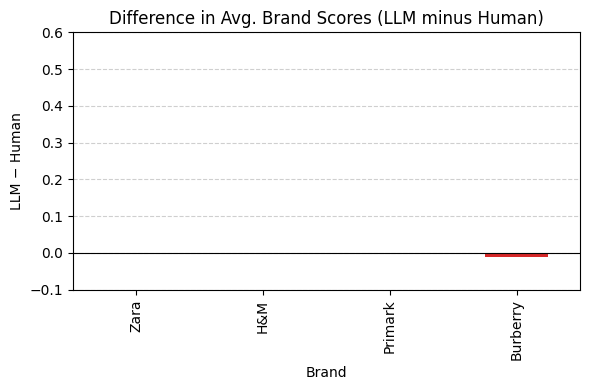

In [ ]:
# Define a list of distinct colors—one per brand
colors = ["#1f77b4",  # muted blue
          "#ff7f0e",  # safety orange
          "#2ca02c",  # cooked asparagus green
          "#d62728"]  # brick red

# Set up figure and axes
fig, ax = plt.subplots(figsize=(6, 4))

# Plot a vertical bar chart, passing the color list
comparison["Diff"].plot.bar(ax=ax, color=colors)

# Reference line at y=0
ax.axhline(0, color="black", linewidth=0.8)

# Dashed grid on the y-axis for easier reading
ax.grid(axis="y", linestyle="--", alpha=0.6)

# Zoom into the data’s actual range
ax.set_ylim(-0.1, 0.6)  # tweak if your diffs exceed this

# Labels and title
ax.set_xlabel("Brand")
ax.set_ylabel("LLM − Human")
ax.set_title("Difference in Avg. Brand Scores (LLM minus Human)")

# Tidy up layout
plt.tight_layout()

# Show it
plt.show()

### Heatmap: Average Brand Score by Prompt Category

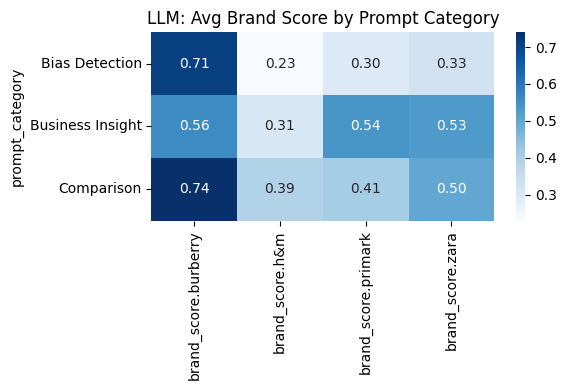

In [ ]:
pivot = (
    llm_eval
    .pivot_table(
        index="prompt_category",
        values=[f"brand_score.{b.lower()}" for b in brands],
        aggfunc="mean"
    )
    .round(2)
)

import seaborn as sns
plt.figure(figsize=(6,4))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".2f",          # force two decimal places
    cmap="Blues",
    annot_kws={"size":10}
)
plt.title("LLM: Avg Brand Score by Prompt Category")
plt.tight_layout()
plt.show()


### Scatter: LLM vs Human Scores (Across brands)

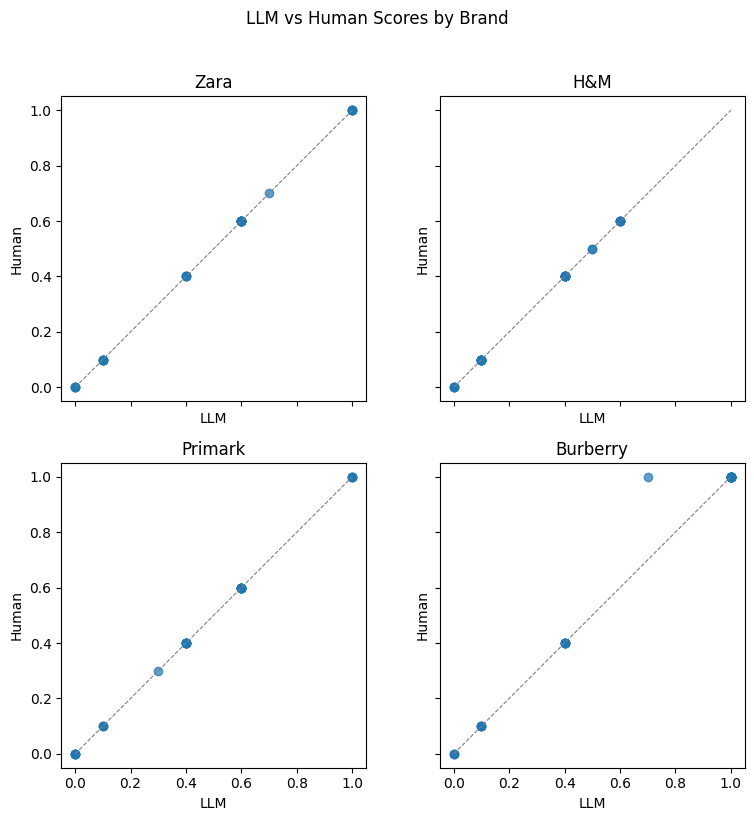

In [ ]:
brands = ['Zara','H&M','Primark','Burberry']
fig, axes = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, b in zip(axes, brands):
    col = f"brand_score.{b.lower()}"
    ax.scatter(llm_eval[col], human_eval[col], alpha=0.7)
    ax.plot([0,1],[0,1], '--', color='gray', linewidth=0.8)
    ax.set_title(b)
    ax.set_xlabel("LLM")
    ax.set_ylabel("Human")
    ax.set_aspect('equal')  # square axis

plt.suptitle("LLM vs Human Scores by Brand", y=1.02)
plt.tight_layout()
plt.show()

### Bar Chart: Average Brand Score ± SD by Evaluator

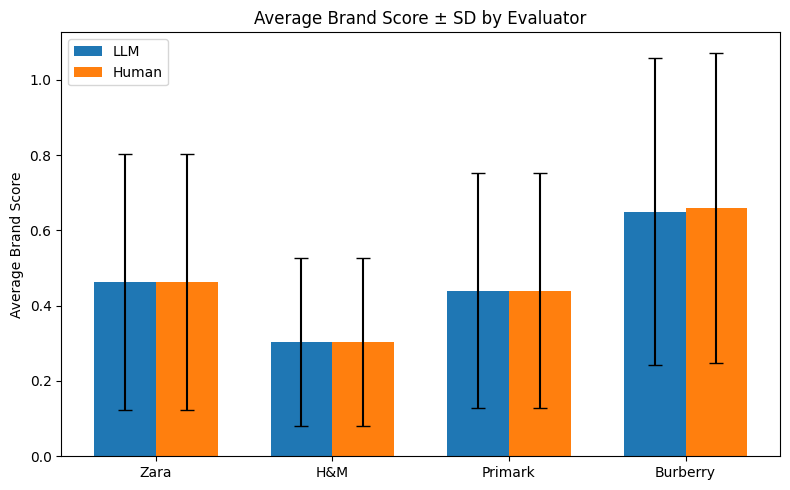

In [ ]:
# Prepare data
brands = ['Zara', 'H&M', 'Primark', 'Burberry']
llm_vals = [llm_eval[f'brand_score.{b.lower()}'] for b in brands]
human_vals = [human_eval[f'brand_score.{b.lower()}'] for b in brands]

llm_means = [v.mean() for v in llm_vals]
llm_stds  = [v.std()  for v in llm_vals]
hum_means = [v.mean() for v in human_vals]
hum_stds  = [v.std()  for v in human_vals]

x = np.arange(len(brands))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, llm_means, width, yerr=llm_stds, label='LLM', capsize=5)
plt.bar(x + width/2, hum_means, width, yerr=hum_stds, label='Human', capsize=5)
plt.xticks(x, brands)
plt.ylabel("Average Brand Score")
plt.title("Average Brand Score ± SD by Evaluator")
plt.legend()
plt.tight_layout()
plt.show()

### Radar Chart: Avg. Brand Scores

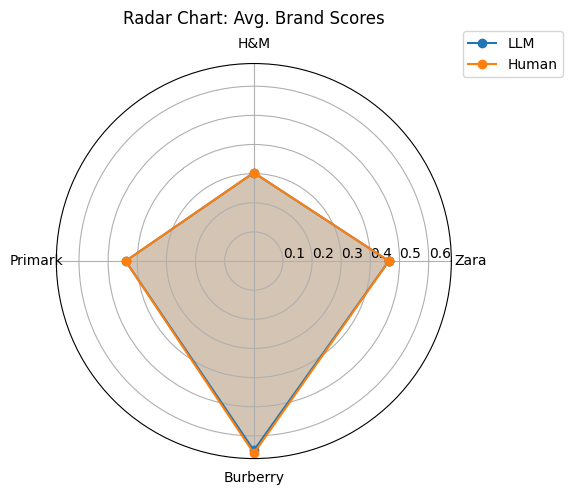

In [ ]:
# Radar data
categories = brands
N = len(categories)
angles = [n/float(N) * 2*math.pi for n in range(N)]
angles += angles[:1]  # close loop

llm_plot = llm_means + llm_means[:1]
hum_plot = hum_means + hum_means[:1]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)

ax.plot(angles, llm_plot,   marker='o', label='LLM')
ax.fill(angles, llm_plot,   alpha=0.25)
ax.plot(angles, hum_plot,   marker='o', label='Human')
ax.fill(angles, hum_plot,   alpha=0.25)

# set ticks & rotated labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
for lbl, angle in zip(ax.get_xticklabels(), angles):
    lbl.set_rotation(angle*180/np.pi + 90)    # rotate to be more radial
    lbl.set_ha('center')                      # center‐align
    lbl.set_va('center')                      # vertical align
    lbl.set_x(lbl.get_position()[0]*1.1)      # push out radially
    lbl.set_y(lbl.get_position()[1]*1.1)

ax.set_title("Radar Chart: Avg. Brand Scores", y=1.08)
ax.set_rlabel_position(0)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


## Save as a checkpoint

Save baseline brand scores to CSV

**Note:** The code block below might have been intentionally hidden to prevent unintentional multiple downloads during testing of the dataset. This is a best practice to avoid redundant operations that may consume unnecessary resources or lead to duplicate file writes.


In [ ]:
# Create baseline: average of LLM and Human averages for each brand
baseline = ((llm_avg + human_avg) / 2).round(2).to_frame(name='Baseline_Avg_Score')
baseline.index.name = 'Brand'

In [ ]:
# Save baseline summary
baseline_path = root / "olmo2_7b_baseline_brand_scores.csv"
baseline.to_csv(baseline_path)

# print(f"Saved baseline brand scores to {baseline_path}")

In [ ]:
# Compute exact‐match agreement for each brand_score column
brand_cols = ['brand_score.zara','brand_score.h&m','brand_score.primark','brand_score.burberry']

llm_bs    = llm_eval.loc[valid, brand_cols]
human_bs  = human_eval.loc[valid, brand_cols]

matches_bs   = llm_bs.round(2) == human_bs.round(2)
agreement_bs = matches_bs.mean().round(2)      # per‐brand Series
overall_bs   = matches_bs.values.mean().round(2)  # single float

# Combine into one Series
olmo_agreement_score = pd.concat([
    agreement_bs.rename(lambda idx: idx.replace('brand_score.', '')),  # optional: clean up index
    pd.Series({'Overall': overall_bs})
])

# display
print("Agreement rate by brand_score + overall:")
display(olmo_agreement_score.to_frame(name='Agreement'))

Agreement rate by brand_score + overall:


,Agreement
zara,1.00
h&m,1.00
primark,1.00
burberry,0.97
Overall,0.99


## Save as a checkpoint

Save agreement score to CSV

**Note:** The code block below might have been intentionally hidden to prevent unintentional multiple downloads during testing of the dataset. This is a best practice to avoid redundant operations that may consume unnecessary resources or lead to duplicate file writes.

In [ ]:
# Save the records
agreement_path = root / "olmo2_7b_instruct_agreement_scores.csv"
olmo_agreement_score.to_csv(agreement_path, header=['Agreement'])

print(f"Saved agreement scores to {agreement_path}")

Saved agreement scores to /content/drive/MyDrive/prompt_shared/baseline_analysis/olmo2/olmo2_7b_instruct_agreement_scores.csv


-- End of the notebook --